# Simulation 1: simulate cluster and batch effect

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/qinzhu/opt/anaconda3/envs/concord/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
proj_name = "simulation_celltype"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)


cpu


In [4]:
import importlib
importlib.reload(ccd)

<module 'Concord' from '/Users/qinzhu/opt/anaconda3/envs/concord/lib/python3.9/site-packages/Concord/__init__.py'>

## Simulation

### 1. Concatenate mode

In [7]:
adata.shape

(80, 72)

Concord.utils.simulation - INFO - Simulating trajectory with 3 states, distribution: normal with mean expression 10 and dispersion 1.0.
Program on time:  120 Program retention time:  24 Program transition time:  48
Gap size:  26.666666666666668
Concord.utils.simulation - INFO - Simulating batch-specific features effect on batch_1 by appending a set of batch-specific genes with normal distributed value with level 10 and dispersion 1.0.


Concord.utils.simulation - INFO - Simulating batch-specific features effect on batch_2 by appending a set of batch-specific genes with normal distributed value with level 10 and dispersion 1.0.


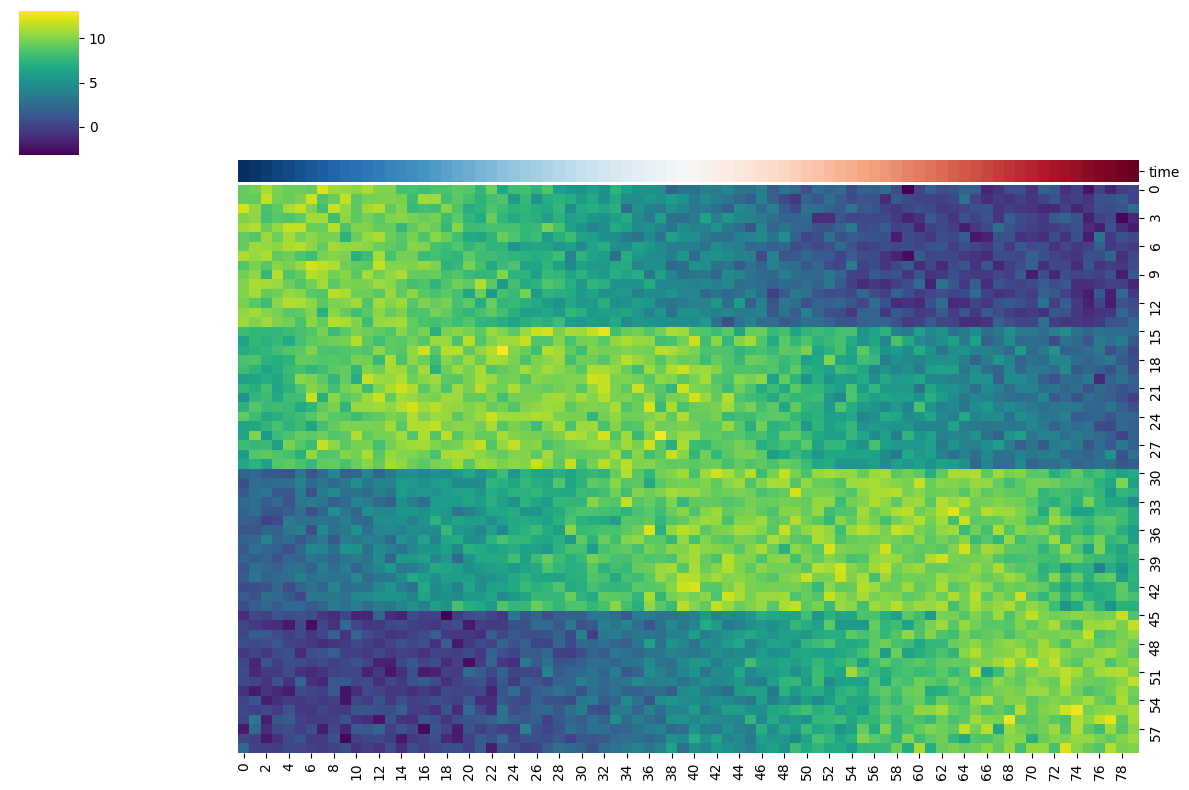

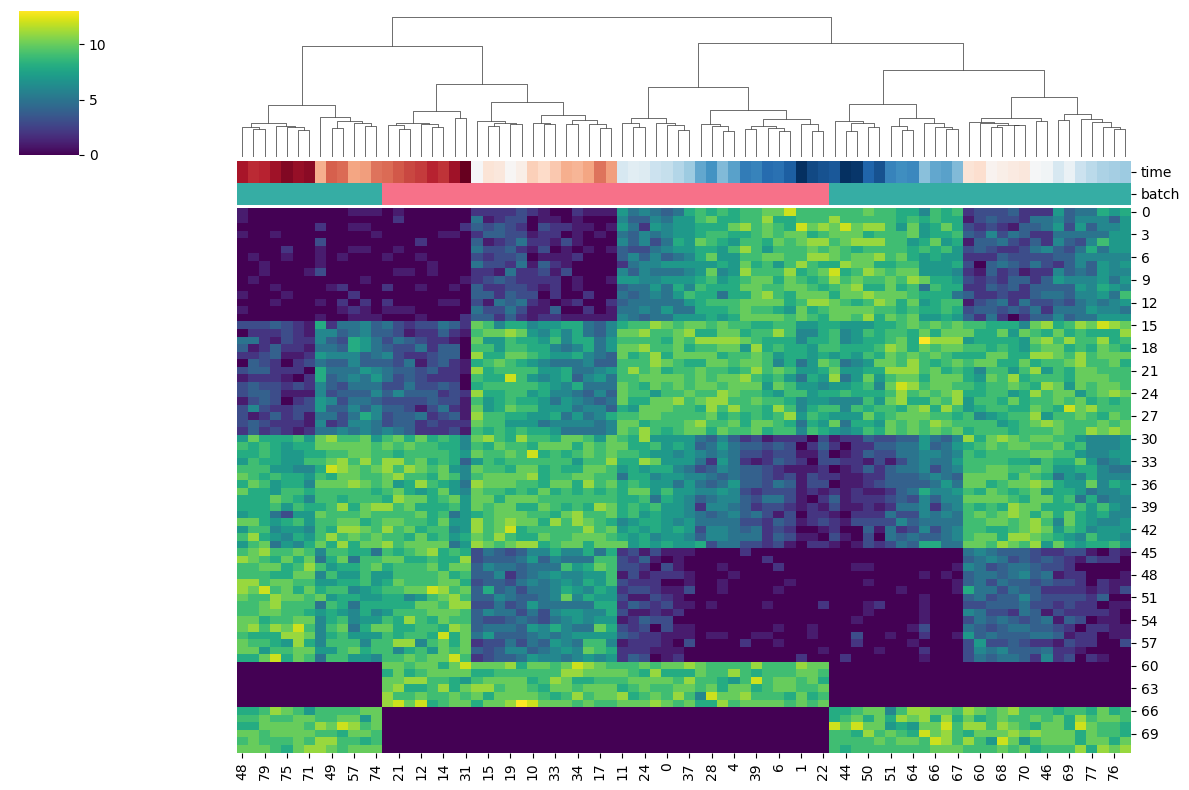

In [17]:
from Concord.utils.simulation import Simulation
#group_key = 'group'
group_key = 'time'
batch_key = 'batch'
# Create an instance of the Simulation class

sim = Simulation(n_cells=80, n_genes=60, n_batches=2, n_states=3, 
                 state_type='trajectory', 
                 state_distribution = 'normal', 
                 state_level=10, 
                 state_dispersion=1.0, 
                 trajectory_trend='both',
                 trajectory_program_num=4,
                 trajectory_program_transition_time=0.6,
                 trajectory_program_retention_time=0.3,
                 batch_distribution = 'normal',
                 batch_type='batch_specific_features', 
                 batch_level=[10,10], 
                 batch_dispersion=[1.0, 1.0], 
                 non_neg=True, to_int=True,
                 seed=42)

# Generate the simulated data
adata, adata_state = sim.simulate_data()
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
ccd.pl.heatmap_with_annotations(adata_state, val='X', obs_keys=[group_key], cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', save_path=save_dir/f'state_heatmap_{file_suffix}.png') 
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=False, value_annot=False, cmap='viridis', save_path=save_dir/f'heatmap_{file_suffix}.png') 

Dropout rate: 0.98


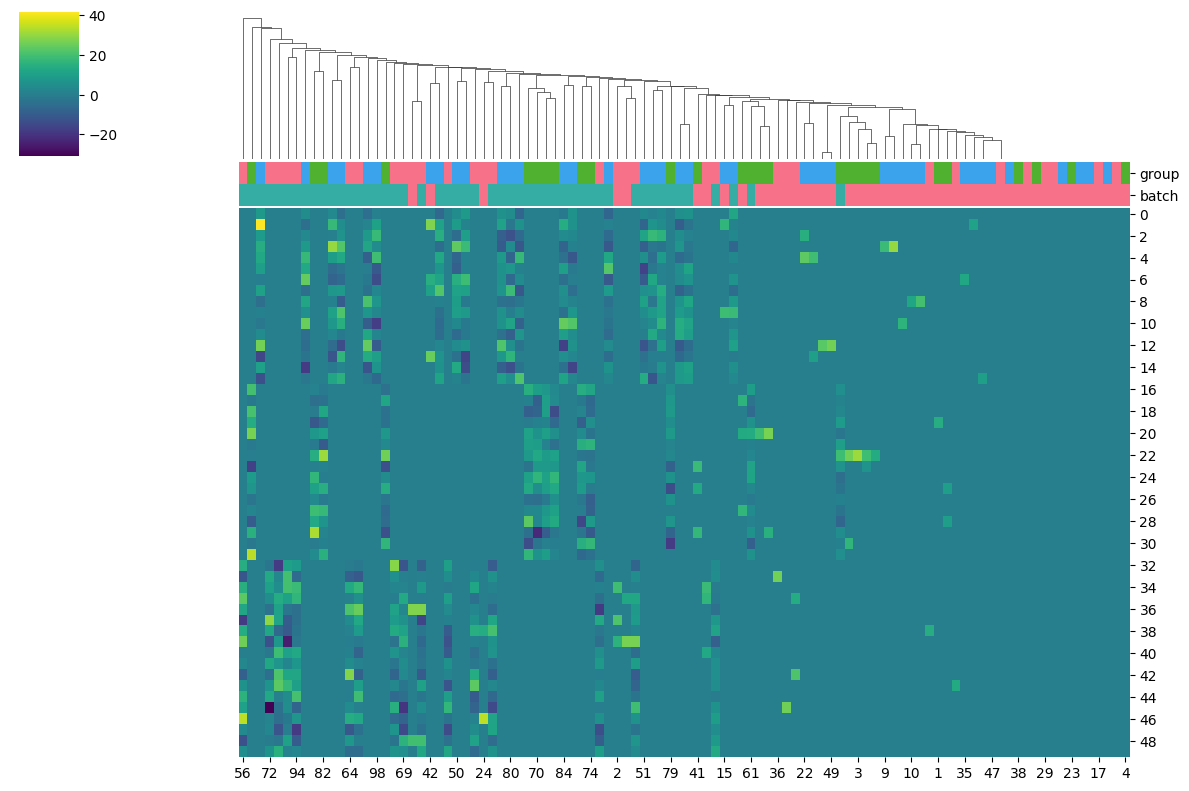

In [444]:
from Concord.utils.simulation import Simulation
group_key = 'group'
batch_key = 'batch'
# Create an instance of the Simulation class
sim = Simulation(n_cells=100, n_genes=50, n_batches=2, n_states=3, 
                 batch_type=['value_dependent_dropout', 'uniform_dropout'], state_type='group', 
                 batch_strength=[0.001, 0.0], state_strength=3, 
                 batch_noise=0.5, state_noise=10.0, 
                 batch_feature_frac = [0.5, 0.5],
                 seed=42)

# Generate the simulated data
adata = sim.simulate_data()
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'ct_heatmap_{file_suffix}.png') 

In [8]:
def rnegbin(n, mu, theta):
    """
    Generate random numbers from a negative binomial distribution.

    Parameters:
    n: Number of random numbers to generate.
    mu: Mean of the distribution.
    theta: Dispersion parameter.
    """
    import numpy as np
    from scipy.stats import nbinom
    p = theta / (theta + mu)
    r = theta
    return nbinom.rvs(r, p, size=n)

np.random.seed(42)
n = 10000
mu = 10
theta = 5
counts_py = rnegbin(n, mu, theta)

print("Empirical Mean:", np.mean(counts_py))
print("Empirical Variance:", np.var(counts_py))
print("Expected Mean:", mu)
print("Expected Variance:", mu + (mu ** 2) / theta)

Empirical Mean: 10.0085
Empirical Variance: 29.694027750000004
Expected Mean: 10
Expected Variance: 30.0


In [380]:
import numpy as np




In [399]:
mtx = np.array([
    [5, 9, 2],   # Gene 1
    [10, 0, 0],  # Gene 2
    [0, 5, 0],   # Gene 3 (no reads)
    [2, 2, 5],   # Gene 4
])

# Downsample the matrix
downsampled_mtx = downsample_mtx_umi(mtx, ratio=0.5, seed=42)

print("Original Matrix:\n", mtx)
print("\nDownsampled Matrix:\n", downsampled_mtx)

Original Matrix:
 [[ 5  9  2]
 [10  0  0]
 [ 0  5  0]
 [ 2  2  5]]

Downsampled Matrix:
 [[2 4 2]
 [4 0 1]
 [0 2 0]
 [0 0 4]]


In [383]:
batch_mode = 'random_add'
adata = add_adatas_to_random_features(adata_ct, adata_batch, reindex_cells=True, seed=42)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png')

NameError: name 'add_adatas_to_random_features' is not defined

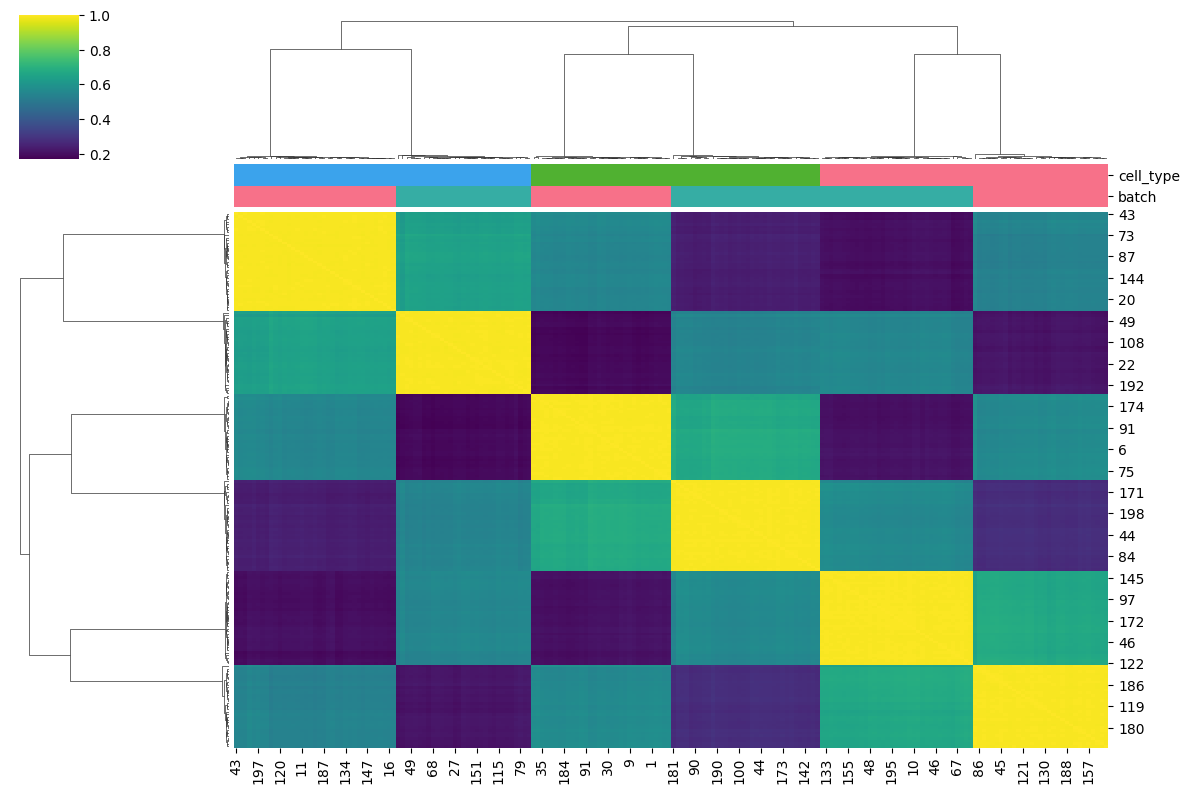

In [762]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png') 

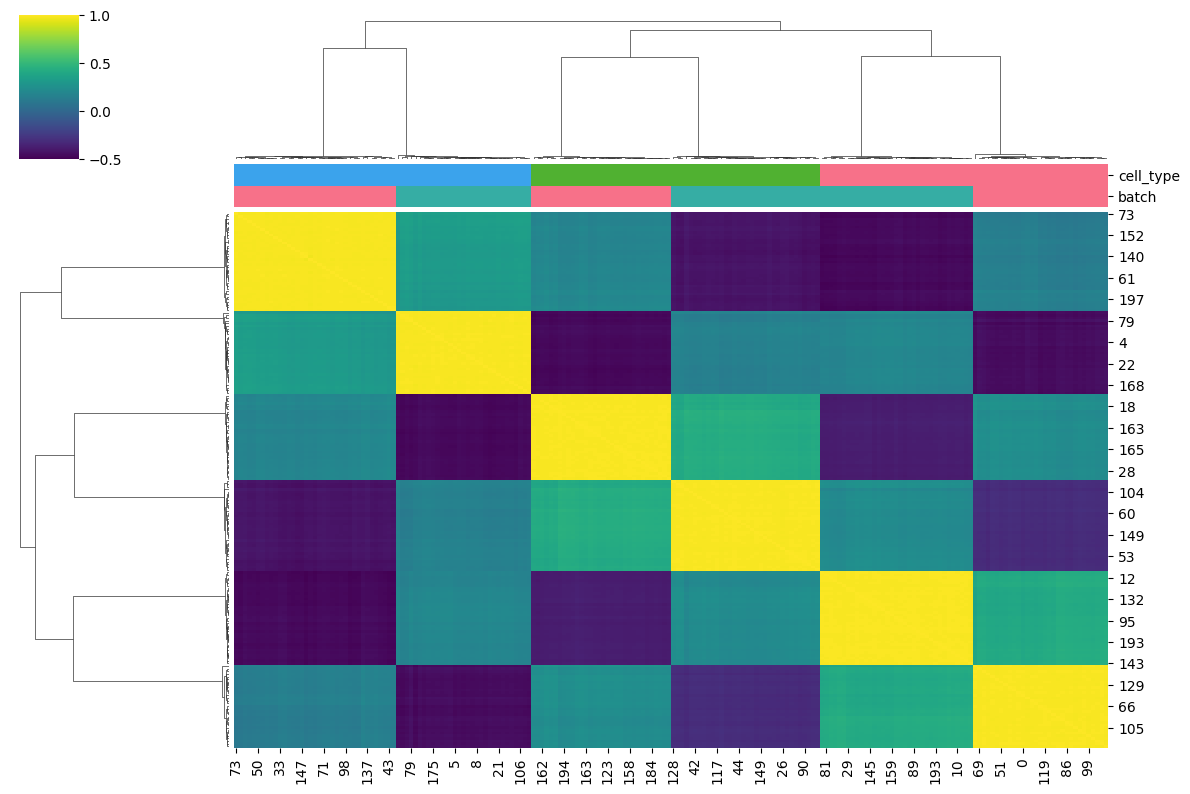

In [763]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

### Approach 2: Simulate batch based on the matrix

In [777]:
import numpy as np
import anndata as ad
import scipy.sparse as sp



#### 2.1 Dropout mode

In [778]:
batch_mode = 'dropout_increase'
adata_b1 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=0.0,
    cell_proportion=0.5,
    batch_name='b1_nodropout',
    seed=43
)

adata_b2 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=.5,
    cell_proportion=0.5,
    batch_name='b2_dropout',
    seed=43
)

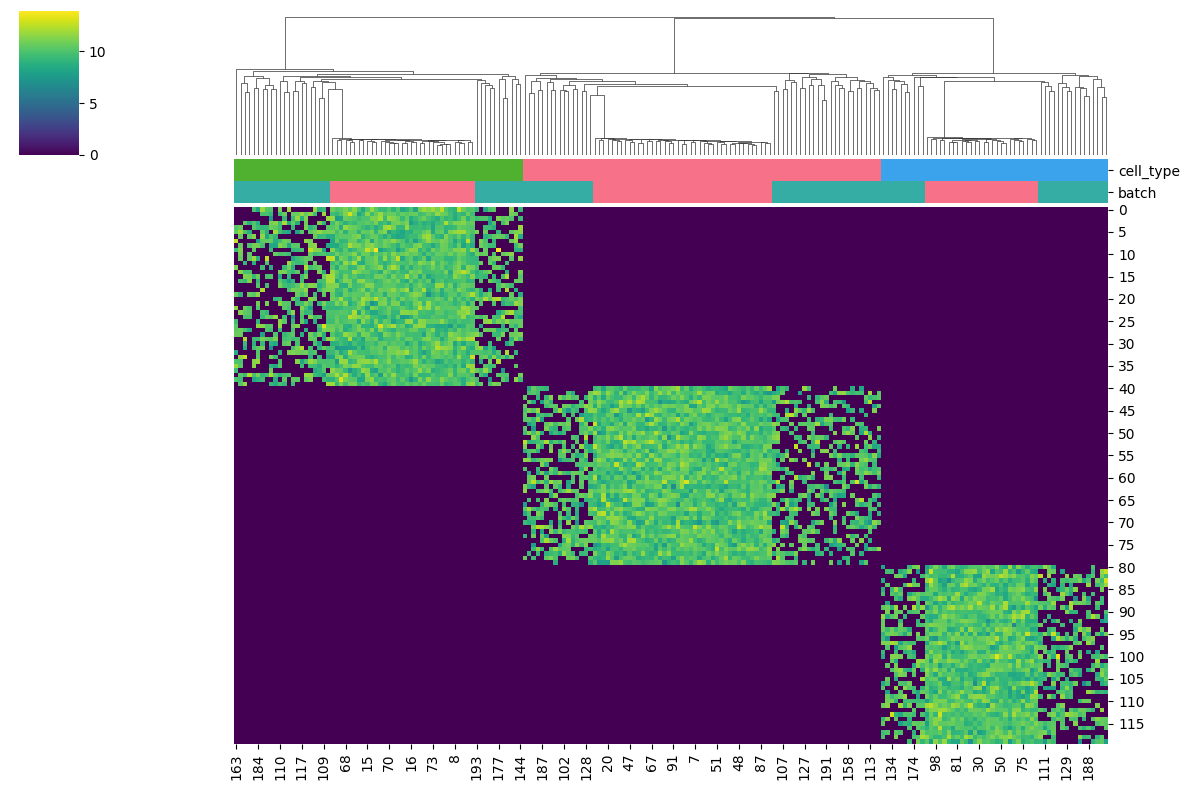

In [779]:
adata = ad.concat([adata_b1, adata_b2], join='outer', index_unique=None)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png')


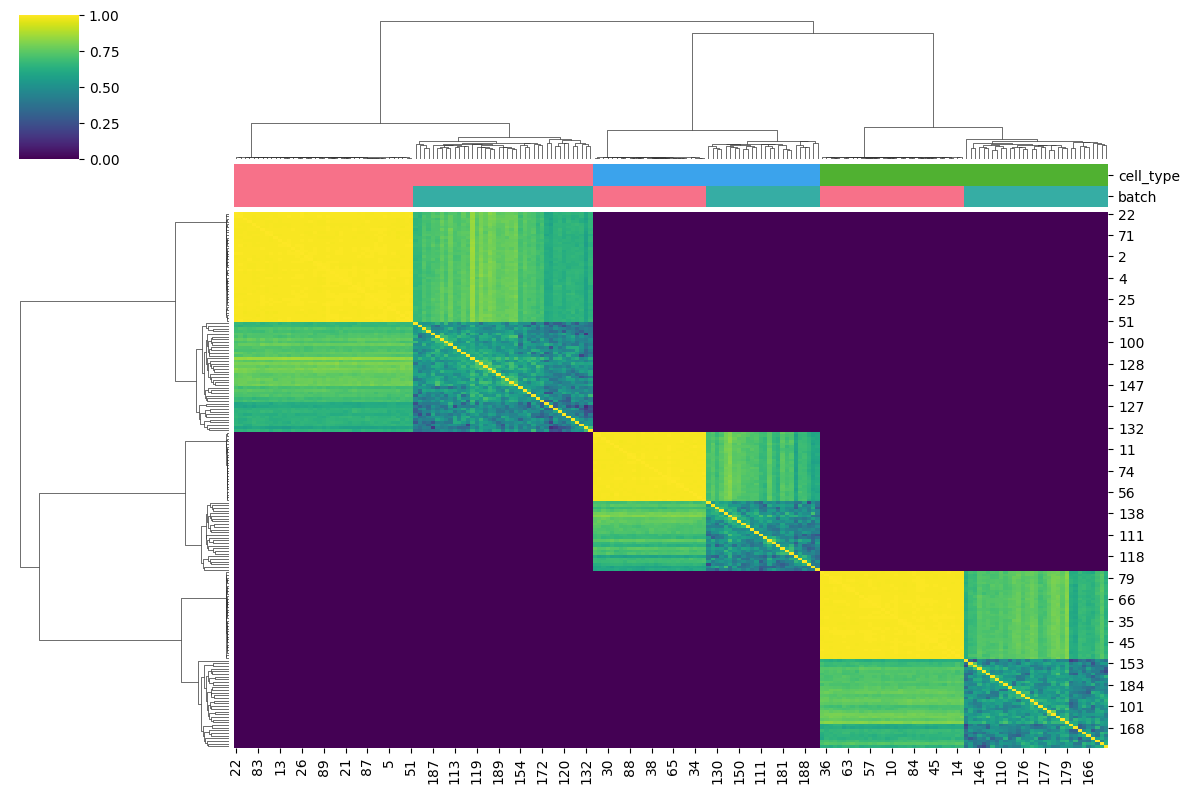

In [780]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png')

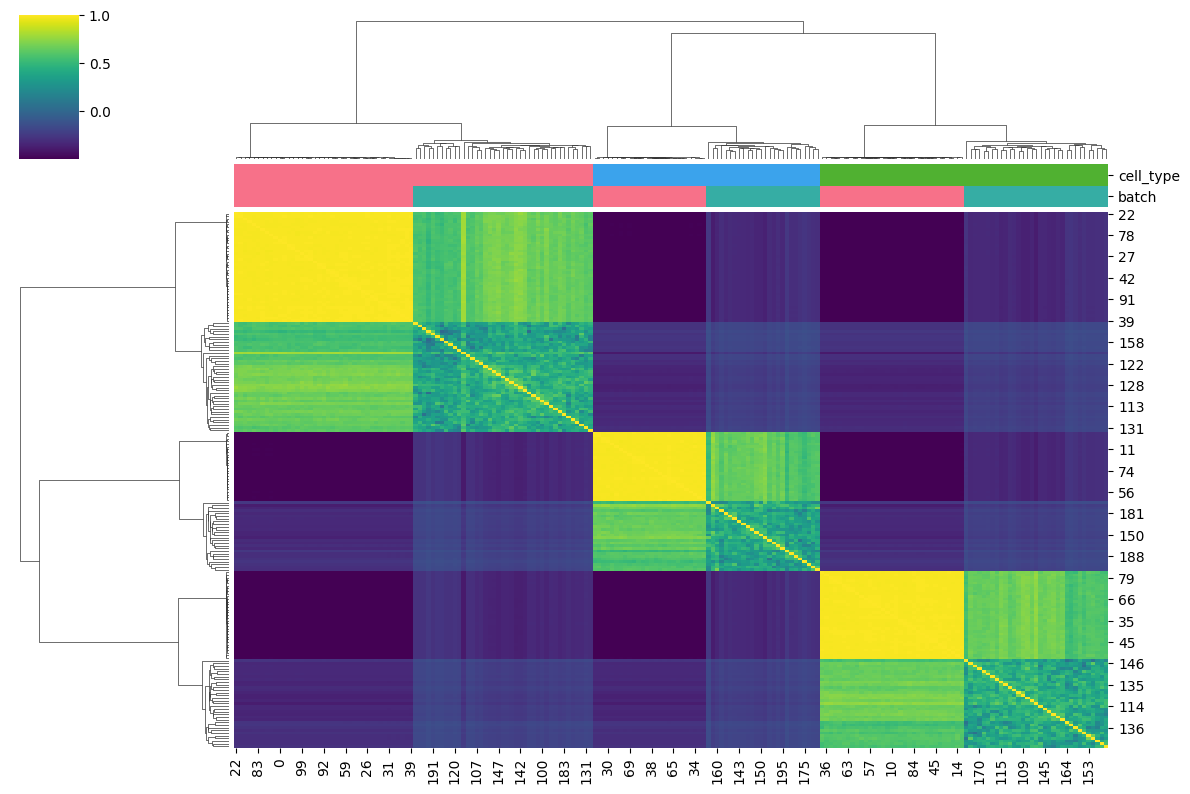

In [781]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

#### 2.2 Scale mode

In [791]:
batch_mode = 'scaling_factor'
adata_b1 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=1.0,
    cell_proportion=0.5,
    batch_name='b1_noscale',
    seed=43
)

adata_b2 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=3.0,
    cell_proportion=0.5,
    batch_name='b2_scale',
    seed=43
)

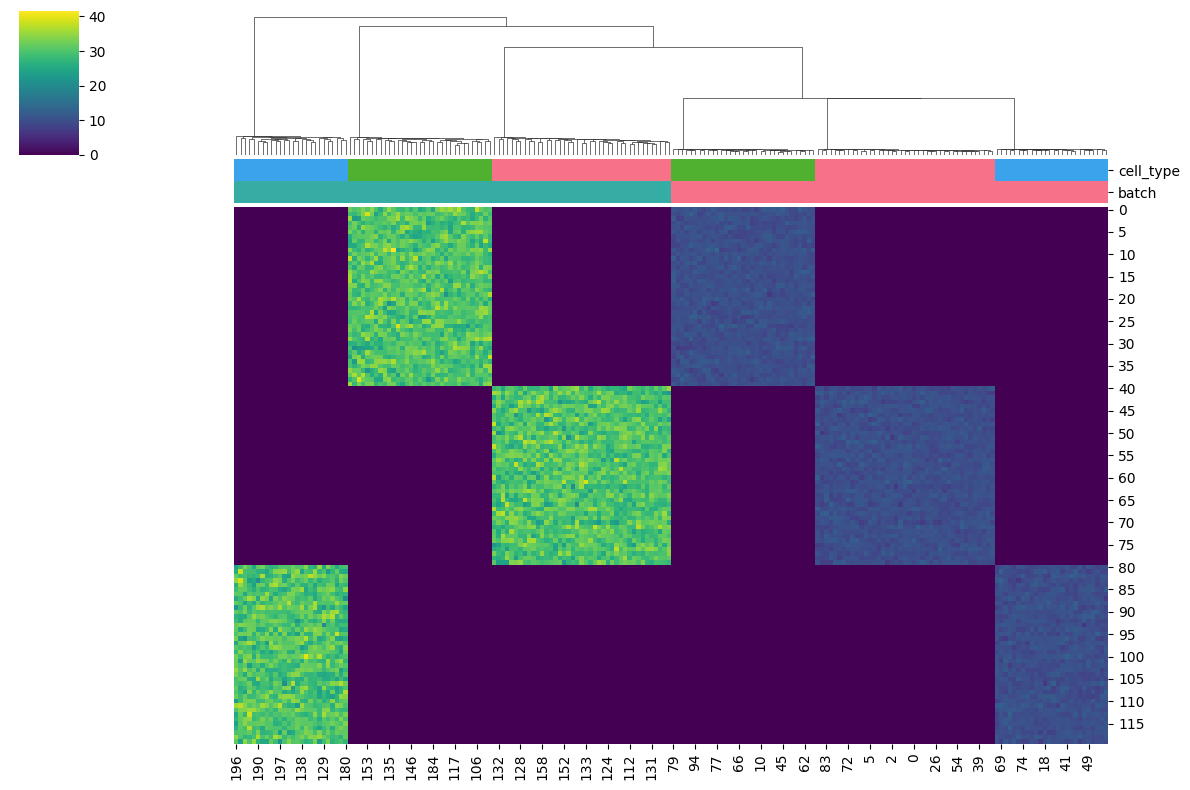

In [792]:
adata = ad.concat([adata_b1, adata_b2], join='outer', index_unique=None)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png')


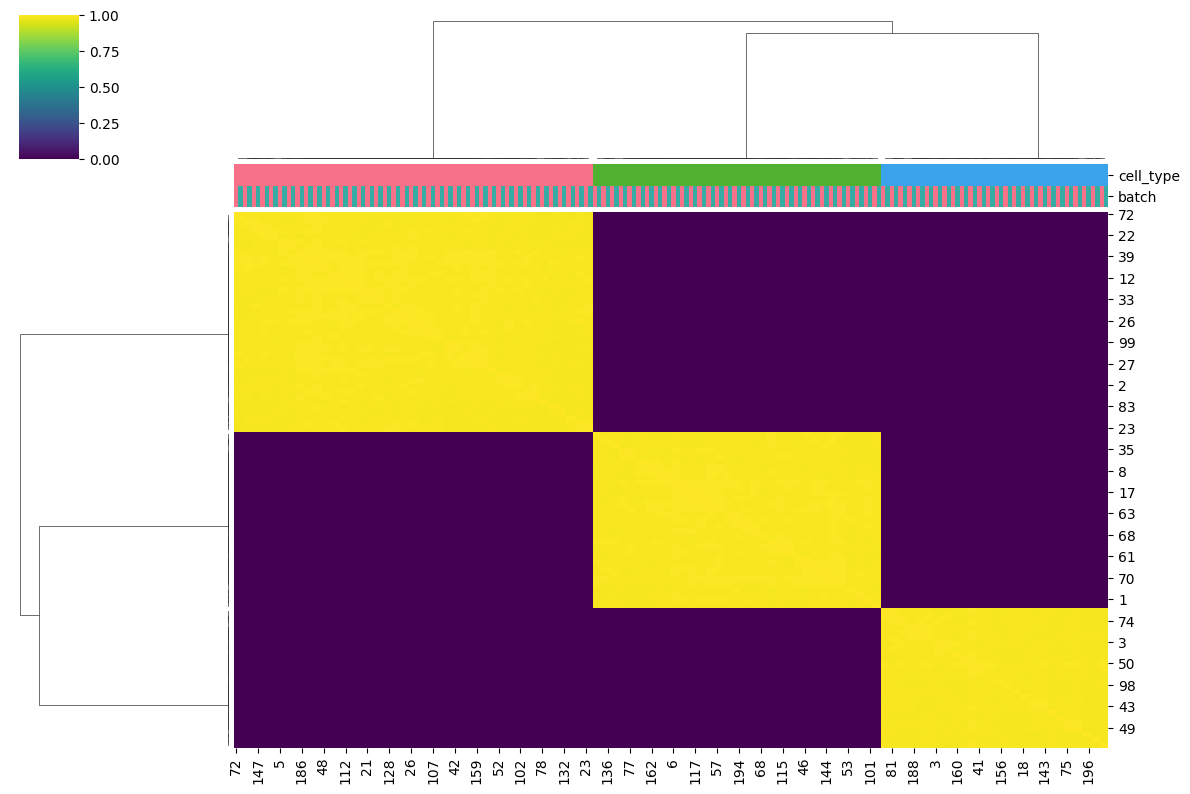

In [793]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png')

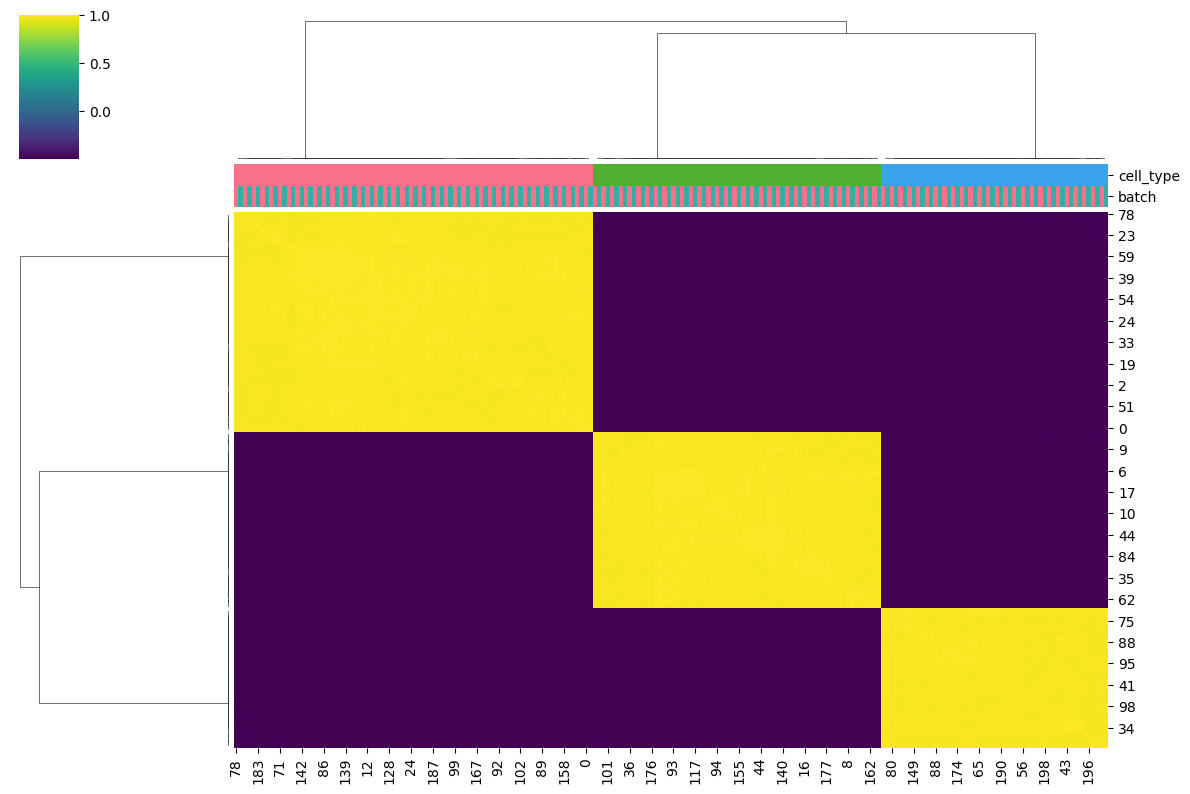

In [794]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

#### 2.3 Variance inflation mode

In [804]:
batch_mode = 'variance_inflation'
adata_b1 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=0.0,
    cell_proportion=0.5,
    batch_name='b1_nodropout',
    seed=43
)

adata_b2 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=1.0,
    cell_proportion=0.5,
    batch_name='b2_dropout',
    seed=43
)

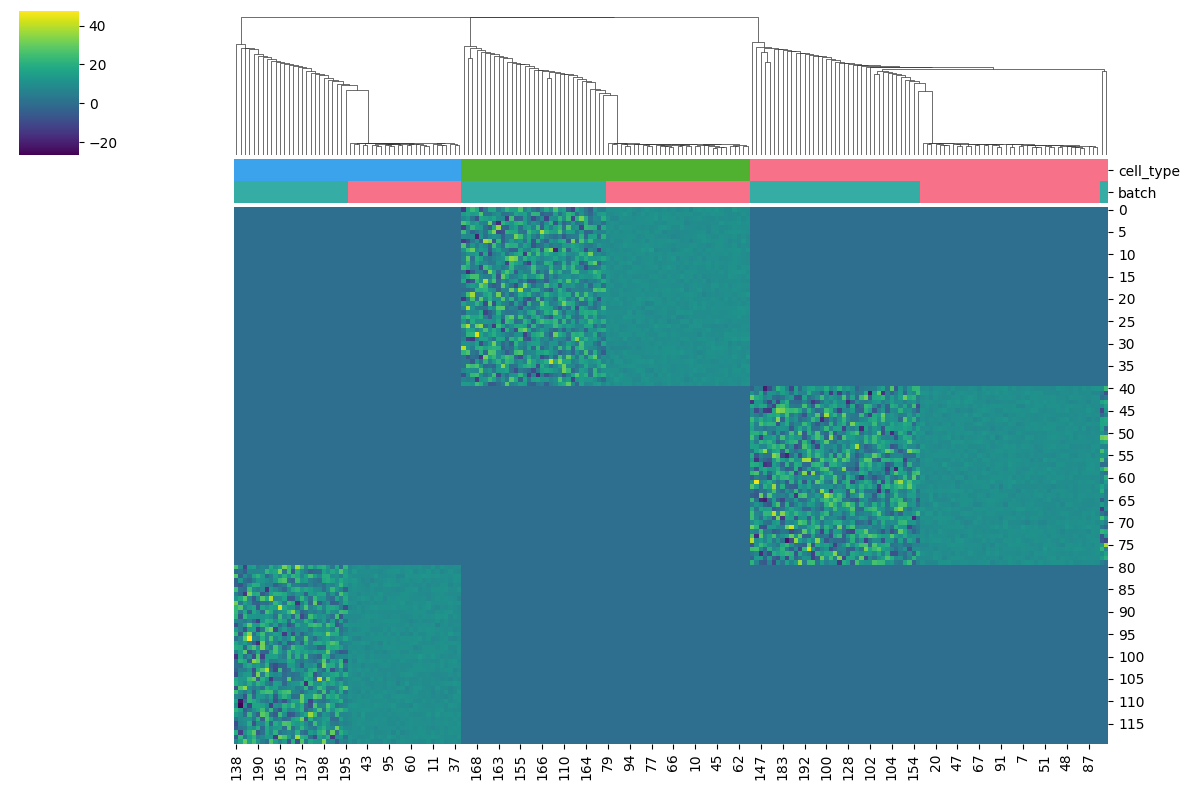

In [805]:
adata = ad.concat([adata_b1, adata_b2], join='outer', index_unique=None)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png') 


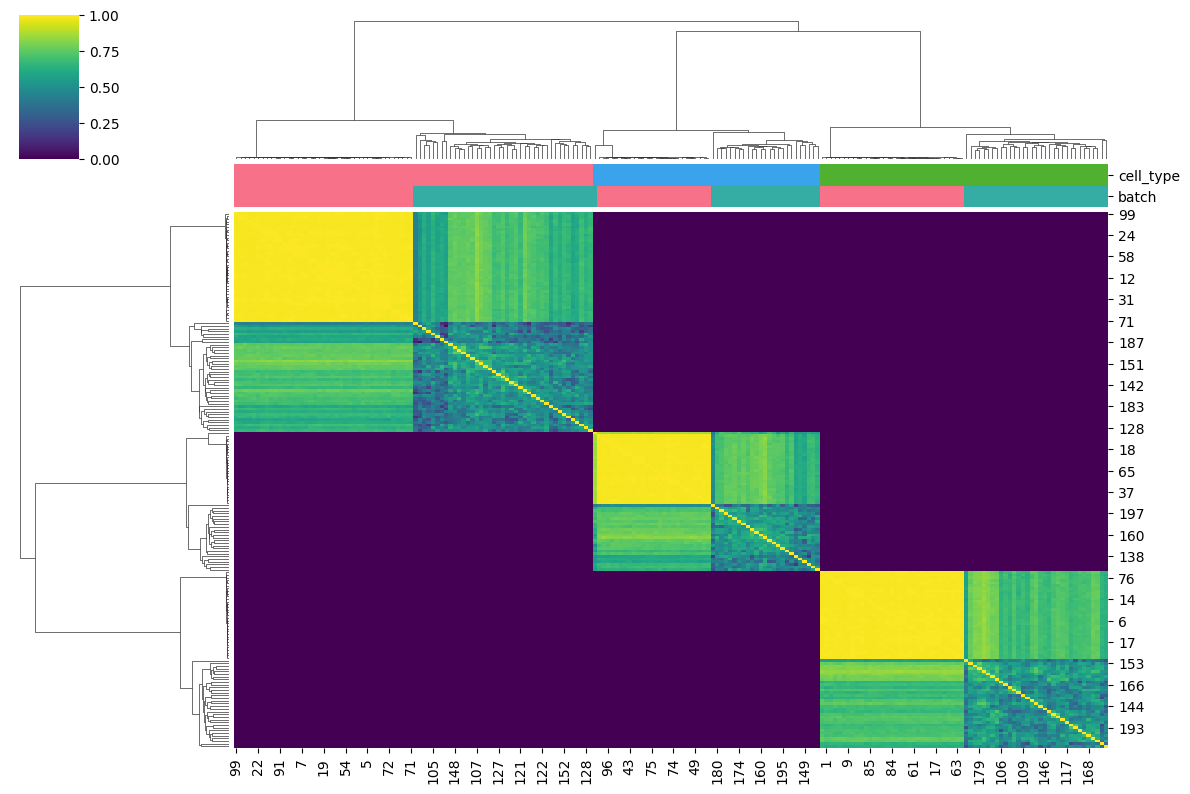

In [806]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png')

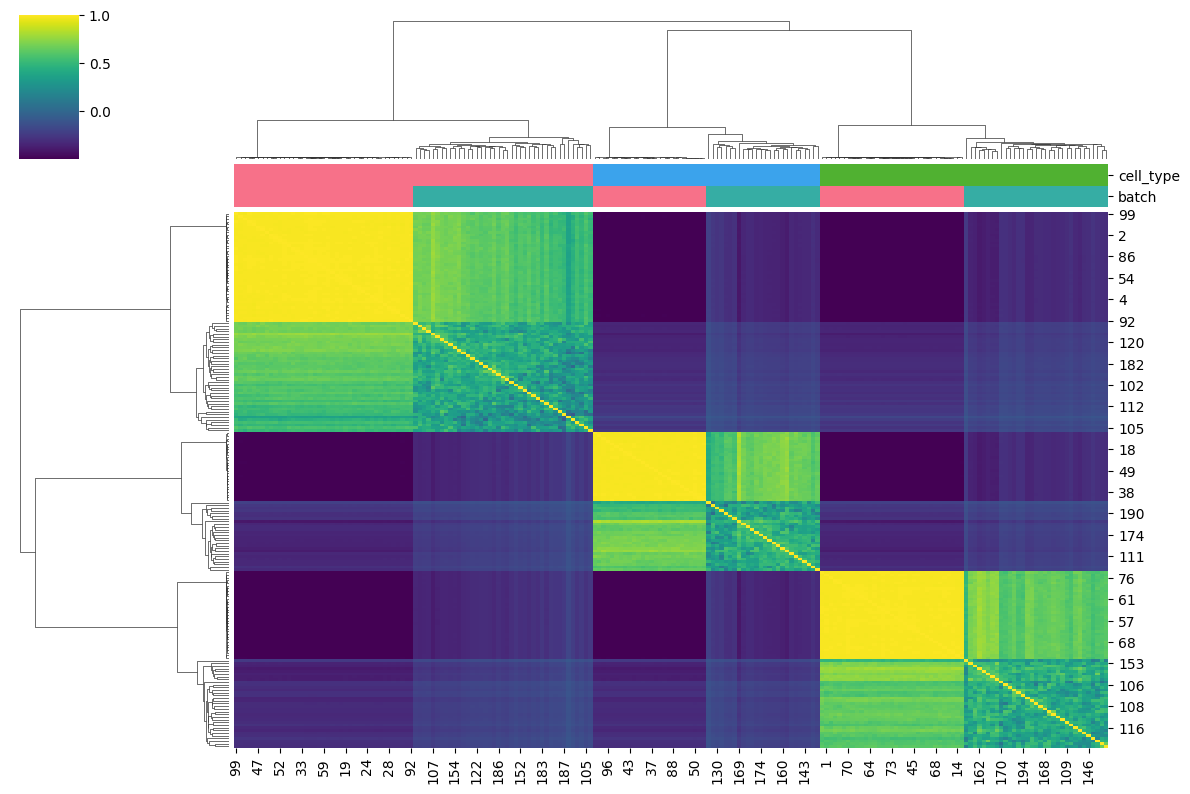

In [807]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

#### 2.4 Mean shift global

In [817]:
batch_mode = 'mean_shift'
adata_b1 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=0.0,
    cell_proportion=0.5,
    batch_name='b1_noscale',
    seed=43
)

adata_b2 = simulate_batch(
    adata_ct,
    effect_type=batch_mode,
    effect_strength=10.0,
    cell_proportion=0.5,
    batch_name='b2_scale',
    seed=43
)

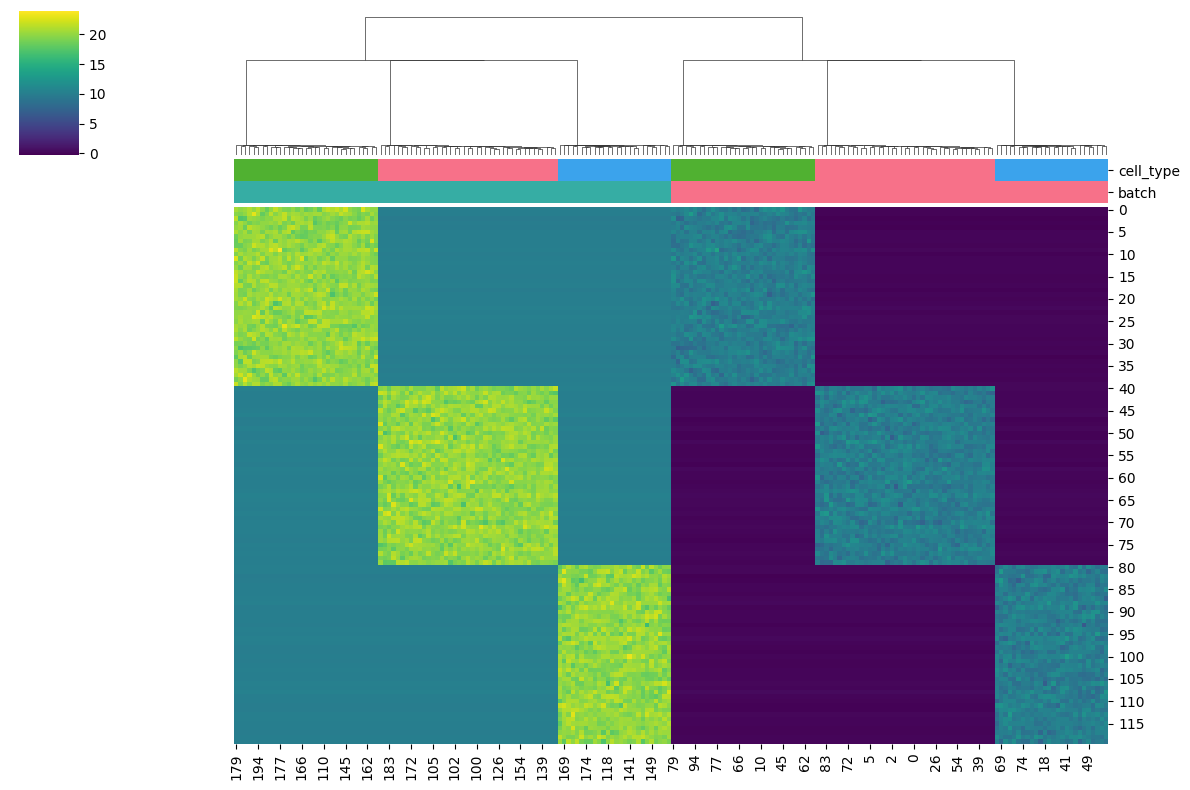

In [818]:
adata = ad.concat([adata_b1, adata_b2], join='outer', index_unique=None)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis', save_path=save_dir/f'{batch_mode}_exprheatmap_{file_suffix}.png')


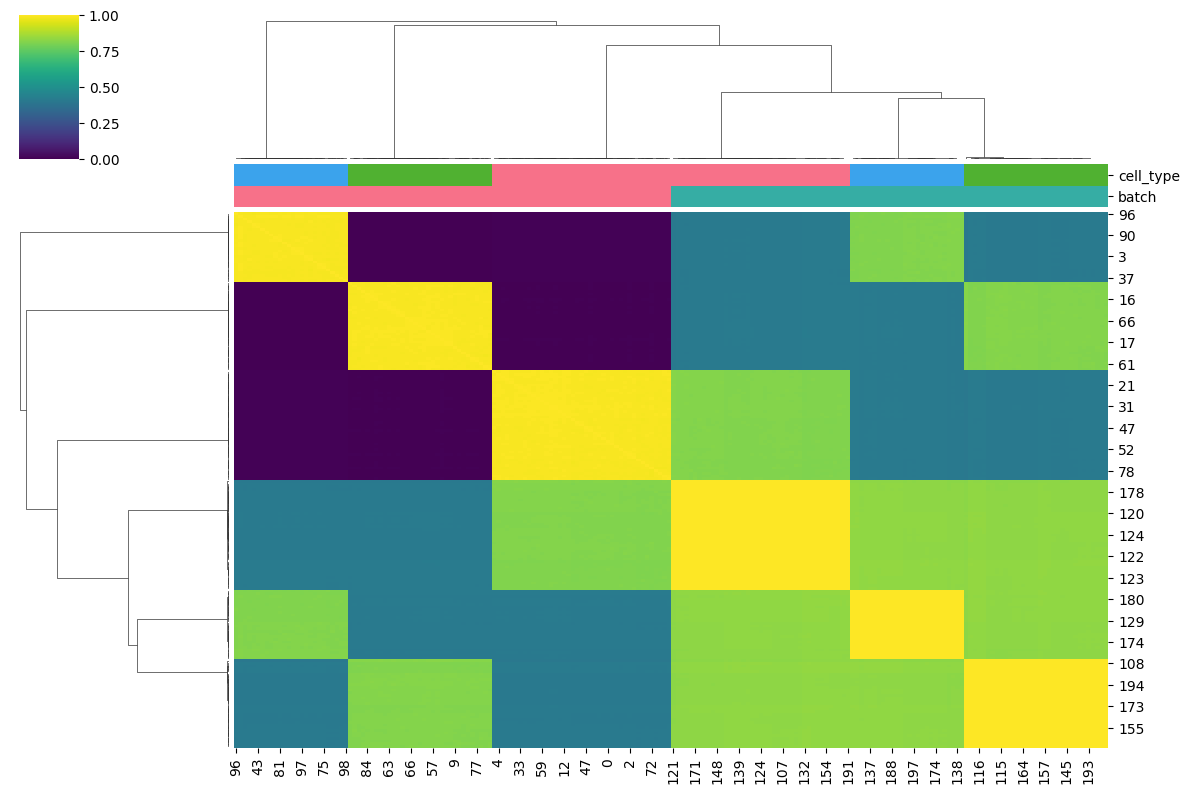

In [819]:
dot_product_matrix = cosine_sim(adata.X)
ccd.pl.heatmap_with_annotations(adata, val=dot_product_matrix, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_cosine_sim_heatmap_{file_suffix}.png') 

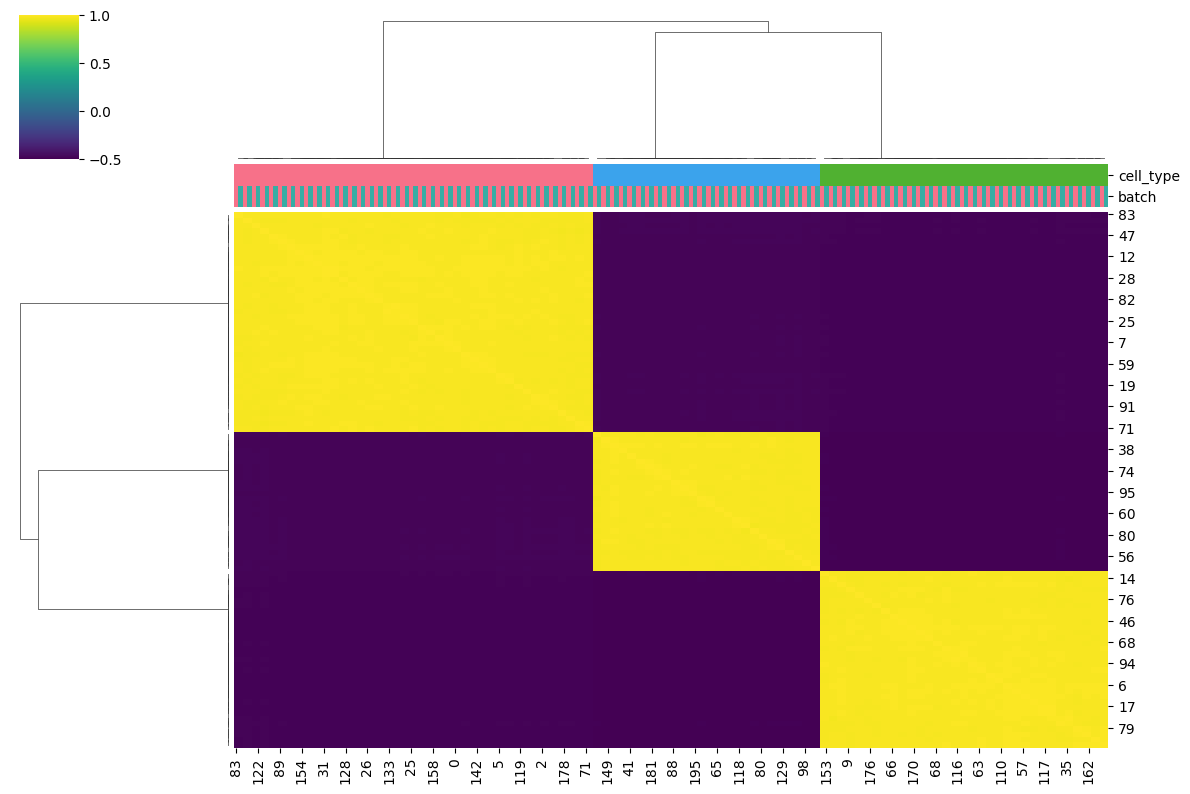

In [820]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.X, rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_correlation_heatmap_{file_suffix}.png')

## Test batch correction

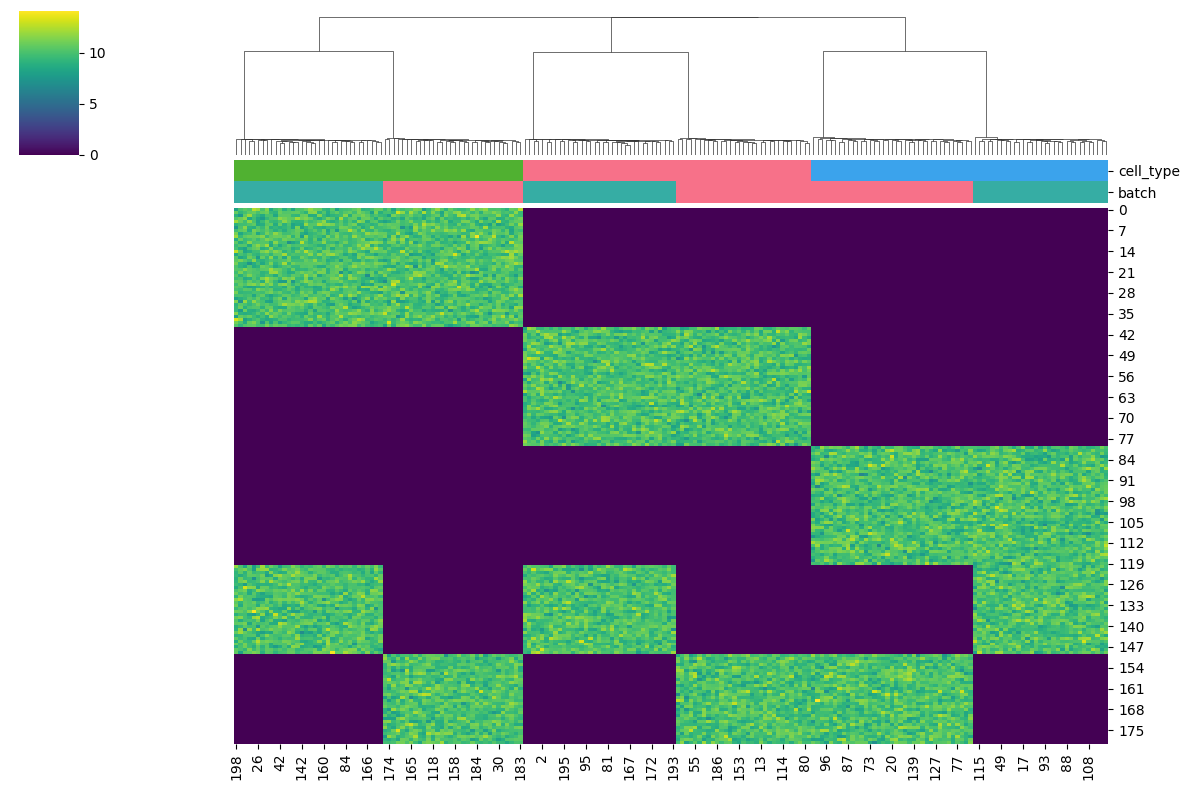

In [25]:
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis')


### No correction

In [11]:
n_pcs = min(adata.n_obs, adata.n_vars)-1
sc.pp.pca(adata, n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.1)

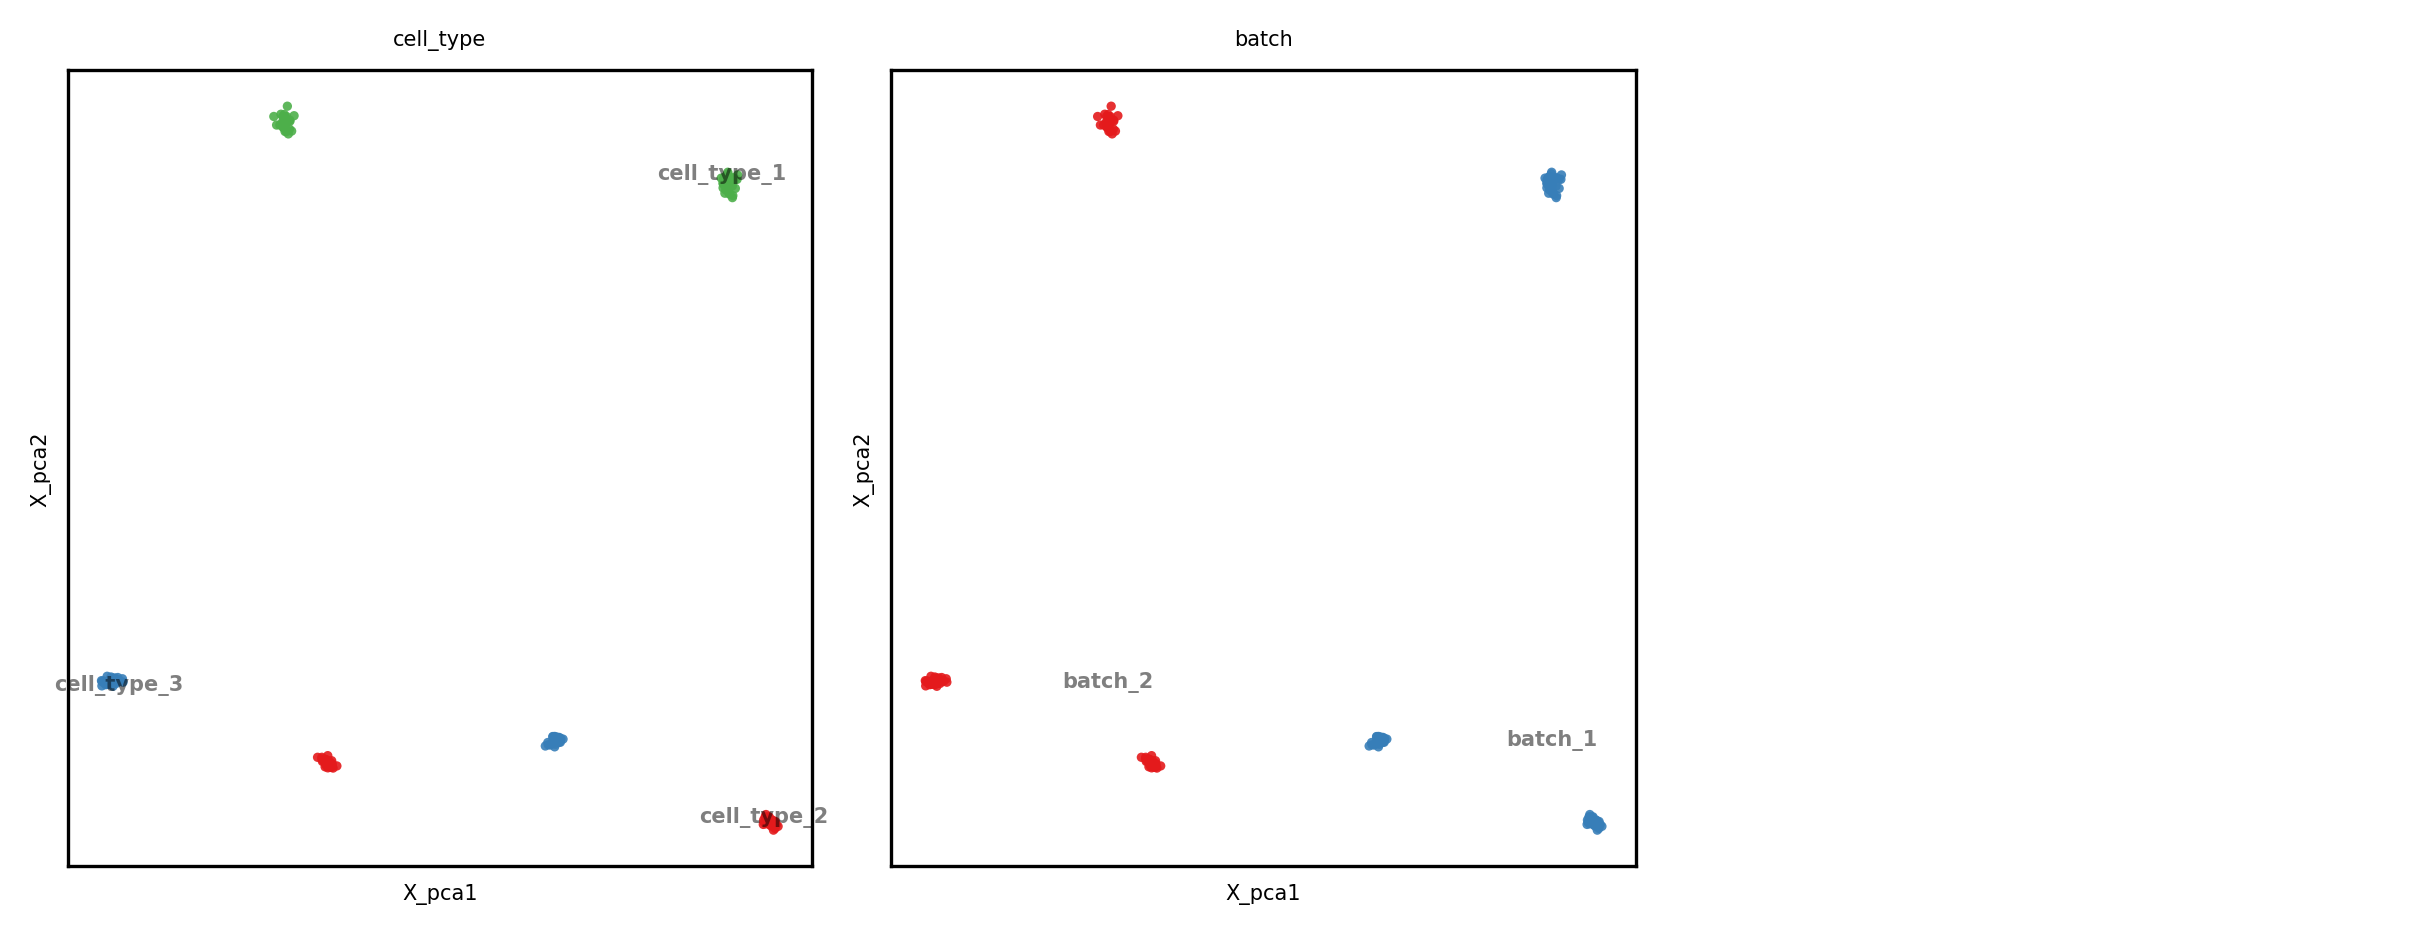

In [12]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]
show_basis = 'X_pca'
show_cols = [group_key, batch_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"{batch_mode}_{show_basis}_{file_suffix}.png"
)

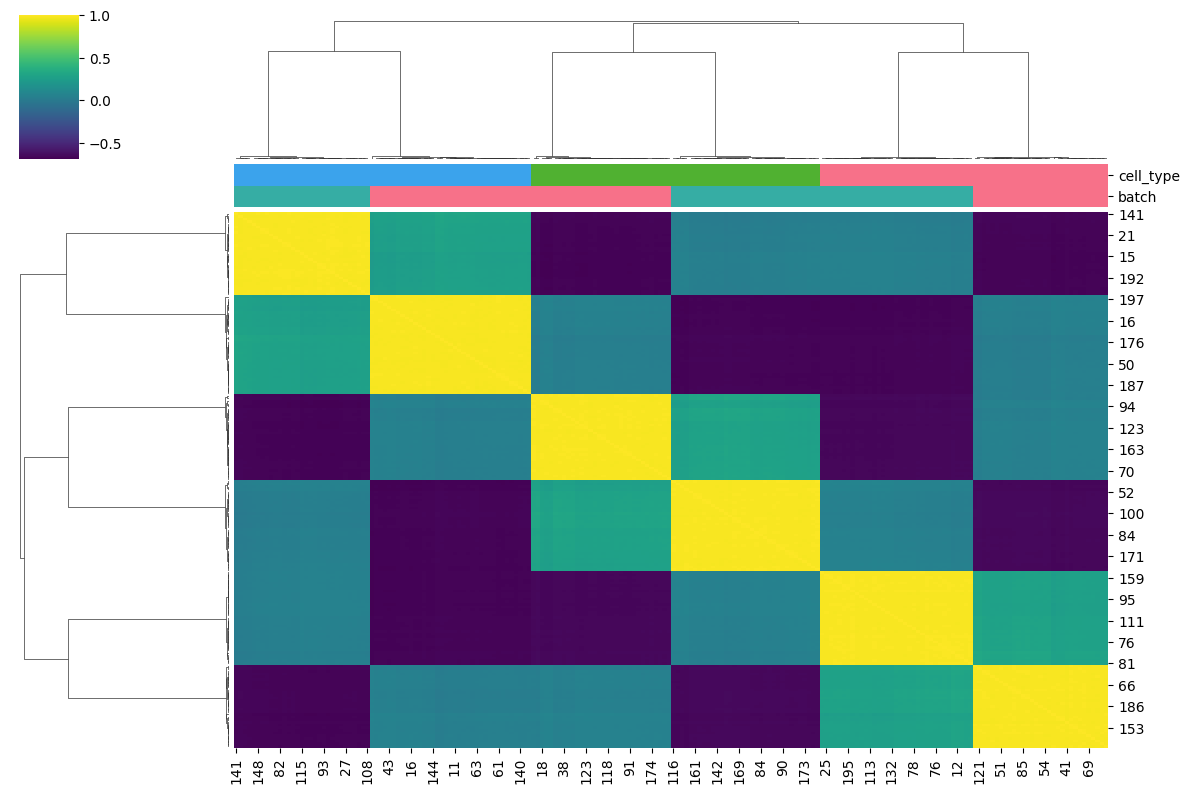

In [13]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata.obsm[show_basis], rowvar=True)
ccd.pl.heatmap_with_annotations(adata, val=cor_mtx, obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_{show_basis}_correlation_{file_suffix}.png')

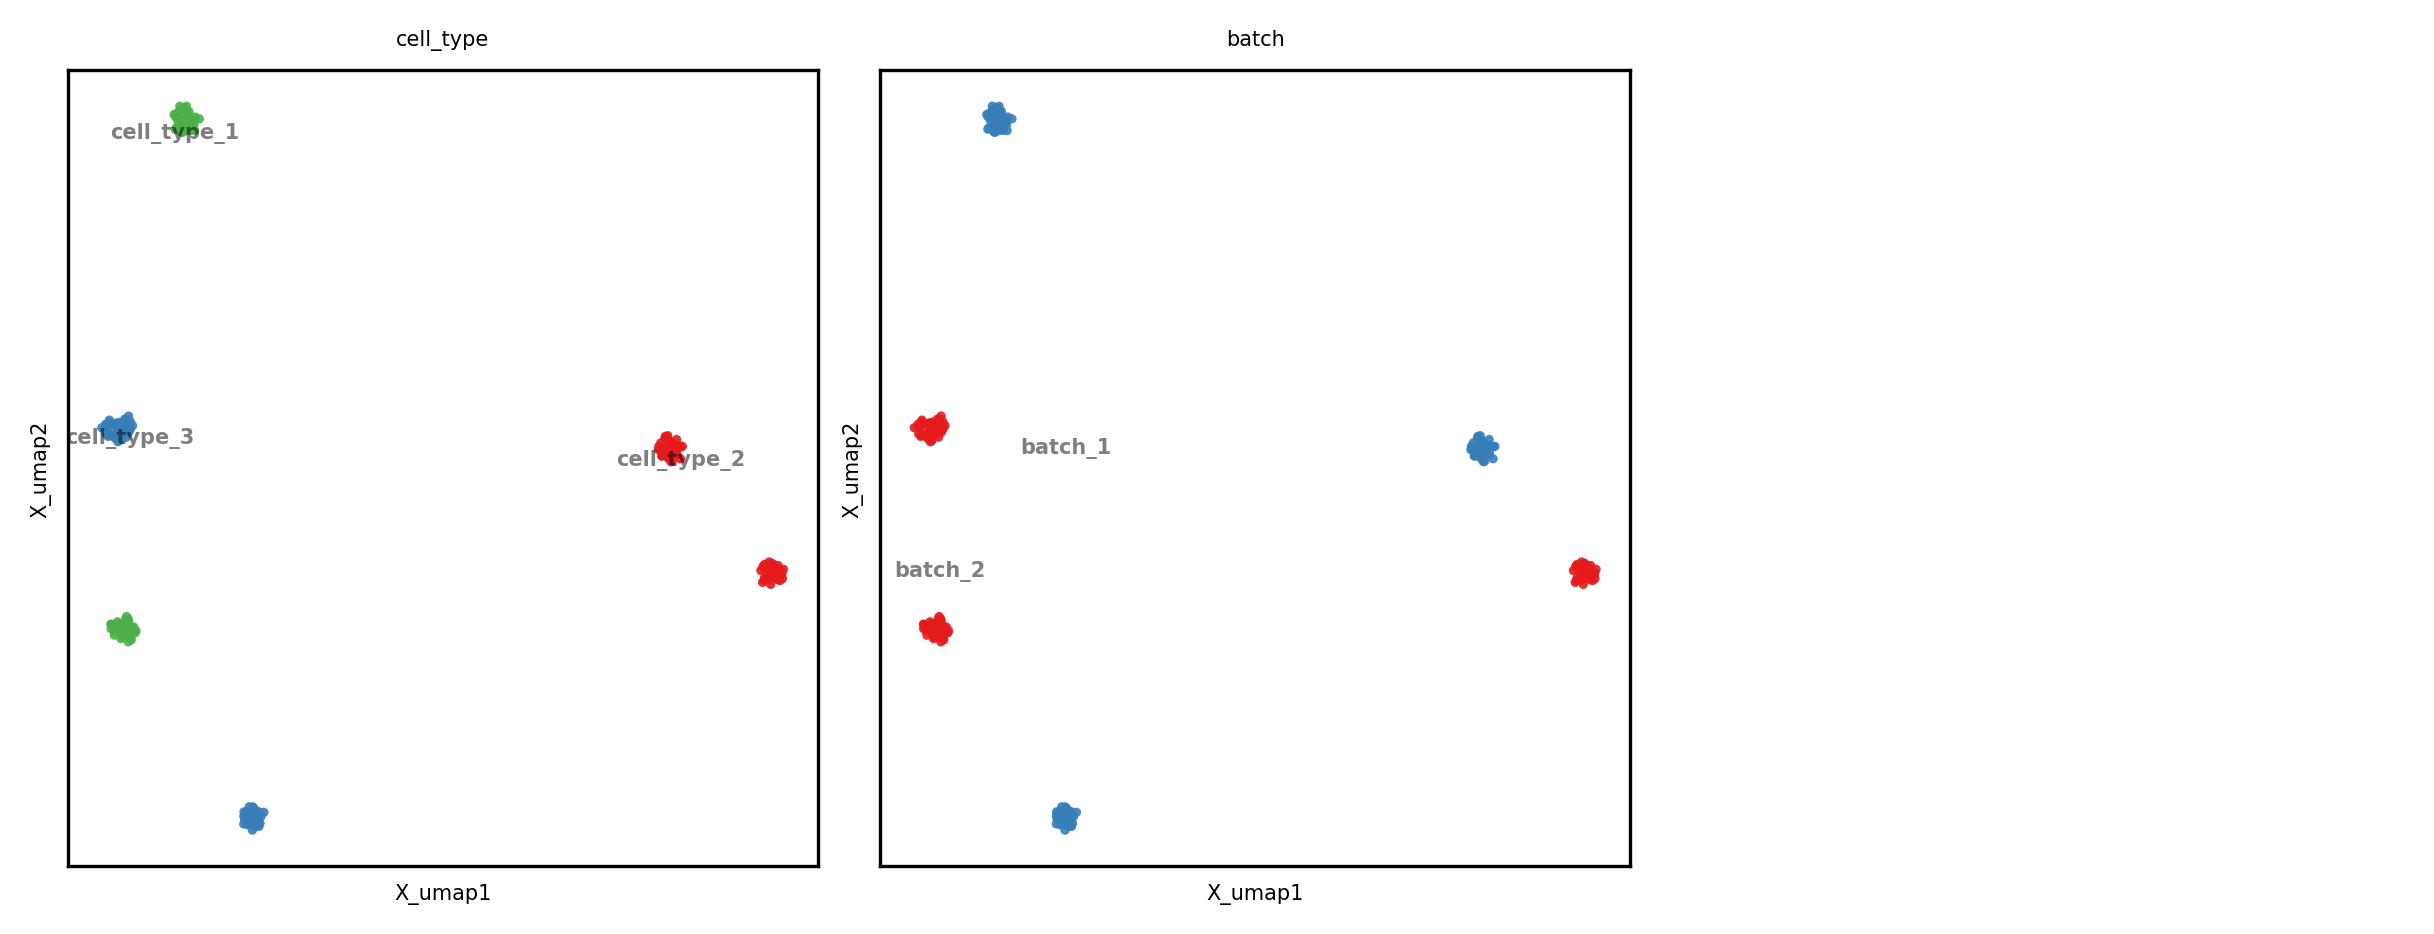

In [14]:
show_basis = 'X_umap'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"{batch_mode}_{show_basis}_{file_suffix}.png"
)

### Concord

In [199]:
import importlib
importlib.reload(ccd)

<module 'Concord' from '/Users/qinzhu/opt/anaconda3/envs/concord/lib/python3.9/site-packages/Concord/__init__.py'>

['batch_1', 'batch_2']
Categories (2, object): ['batch_1', 'batch_2']


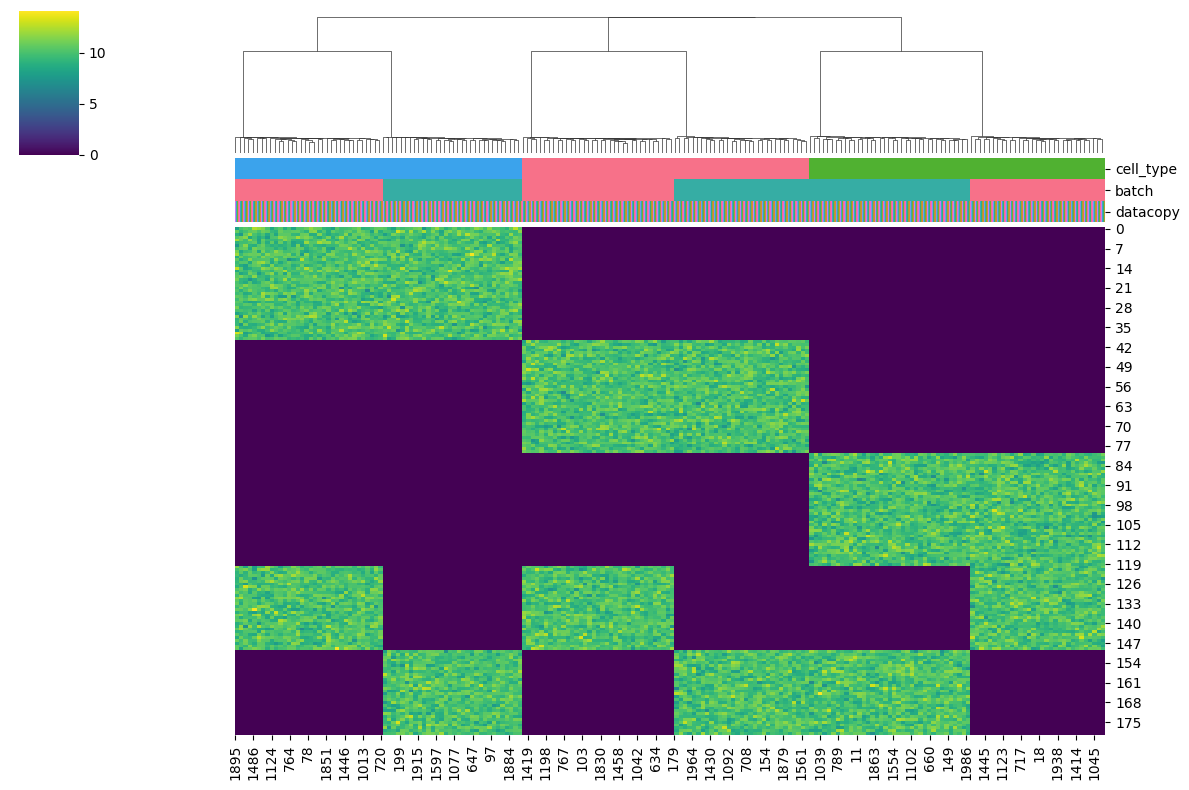

In [200]:
import numpy as np
import anndata as ad
from simulation import permute_and_concatenate_adata_independent

# Example usage
adata.obs['original_idx'] = adata.obs_names
adata_permuted = permute_and_concatenate_adata_independent(adata, x=10)

ccd.pl.heatmap_with_annotations(adata_permuted, val='X', obs_keys=[group_key, batch_key, 'datacopy'], cluster_cols=True, cluster_rows=False, cmap='viridis')

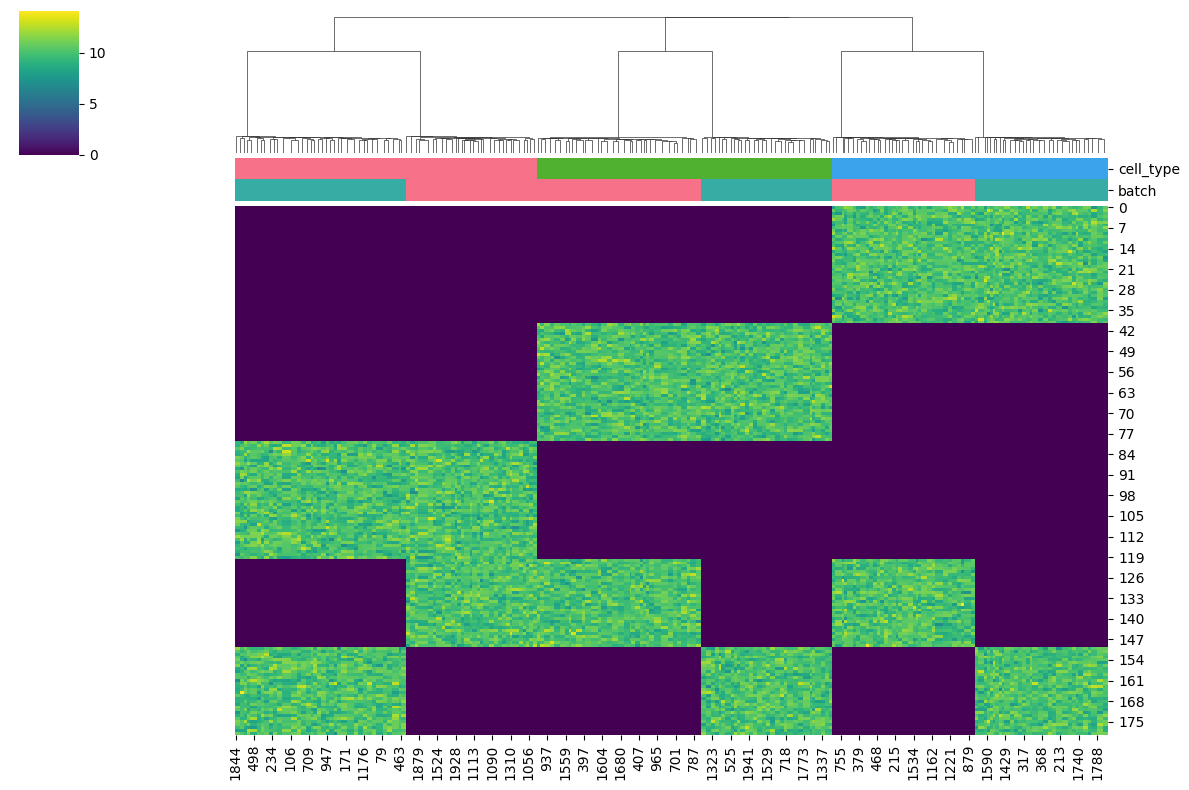

In [201]:
ncells_sample = adata.shape[0] * 10
adata_sampled = adata.copy()[np.random.choice(adata.obs_names, ncells_sample, replace=True), :]
ccd.pl.heatmap_with_annotations(adata_sampled, val='X', obs_keys=[group_key, 'batch'], cluster_cols=True, cluster_rows=False, cmap='viridis')


In [202]:
import importlib
importlib.reload(ccd)

<module 'Concord' from '/Users/qinzhu/opt/anaconda3/envs/concord/lib/python3.9/site-packages/Concord/__init__.py'>

In [213]:
amp_mode = 'permute'
#amp_mode = 'sample'
#amp_mode = 'none'
adata_train = adata_permuted if amp_mode == 'permute' else adata_sampled if amp_mode == 'sample' else adata
    
cur_ccd = ccd.Concord(adata=adata_train, 
                      input_feature=None, 
                      batch_size=10,
                      n_epochs=5,
                      latent_dim=10, # latent dimension
                      encoder_dims = [30], # encoder architecture
                      decoder_dims = [30], # decoder architecture
                      norm_type = 'layer_norm',
                      use_importance_mask=False,
                      #importance_penalty_weight=1.0,
                      use_decoder=False,
                      domain_embedding_dim=8,
                      domain_key=batch_key, # key indicating batch
                      augmentation_mask_prob = 0.2, # augmentation mask probability, recommend between 0.1 and 0.7
                      clr_temperature = 0.5, # temperature for NT-Xent loss
                      seed=seed, # random seed
                      p_intra_domain = 1.0, # probability of intra-domain sampling
                      p_intra_knn=0.0,
                      verbose=False, # print training progress
                      inplace=True, # whether to modify original adata, set to False if you want to keep all expressions
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{batch_mode}_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.


Epoch 0 Training: 200it [00:00, 251.33it/s, loss=2.23]
Epoch 4 Training: 100%|██████████| 200/200 [00:00<00:00, 259.28it/s, loss=2.1] 


In [214]:
torch.randperm(torch.tensor(10)*5)

tensor([27, 30, 16, 34, 39, 17, 20, 22,  9, 38, 29, 42, 14, 41, 35,  0, 46,  6,
        11,  7, 13,  4,  5, 12, 10, 48, 43, 23,  2, 49, 21,  1, 26, 31, 15, 24,
         8, 33, 37, 18, 32, 25, 45, 28, 44, 36,  3, 19, 40, 47])

In [215]:
cur_ccd.init_model()
cur_ccd.init_dataloader(input_layer_key='X', preprocess=False, train_frac=1.0, use_sampler=True)
#cur_ccd.init_trainer()
#cur_ccd.train(save_model=save_model)

Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.


In [206]:
# Save the index of each data point in the training set

import numpy as np

batch_indices = []
for epoch in range(cur_ccd.config.n_epochs):
    for chunk_idx, (train_dataloader, val_dataloader, _) in enumerate(cur_ccd.loader):
        for i, data in enumerate(train_dataloader):
            data_dict = {key: value for key, value in zip(cur_ccd.data_structure, data)}
            # Append each batch's indices as a new list (row) to batch_indices
            batch_indices.append(data_dict['idx'].tolist())

# Convert the list of lists to a numpy array
batch_indices_array = np.array(batch_indices)
batch_indices_array 

array([[ 89, 142,  46, ..., 106,  12, 148],
       [  5, 146, 104, ...,   7,  90, 131],
       [184, 187, 110, ..., 127,  86, 120],
       ...,
       [ 99, 180,  47, ..., 125, 129, 120],
       [170,  75,   0, ..., 127,  35, 183],
       [ 38,  77, 105, ..., 174,  94,  77]])

In [216]:
import numpy as np

batch_indices = []
for epoch in range(cur_ccd.config.n_epochs):
    for chunk_idx, (train_dataloader, val_dataloader, _) in enumerate(cur_ccd.loader):
        for i, data in enumerate(train_dataloader):
            data_dict = {key: value for key, value in zip(cur_ccd.data_structure, data)}
            # Append each batch's indices as a new list (row) to batch_indices
            batch_indices.append(data_dict['idx'].tolist())

# Convert the list of lists to a numpy array
batch_indices_array2 = np.array(batch_indices)
batch_indices_array2 

array([[ 726,  326,  738, ..., 1035,  711,  726],
       [1618, 1133, 1093, ...,  128, 1458,  451],
       [ 478, 1462, 1192, ...,  587,  663, 1848],
       ...,
       [1006,  427,  476, ...,  353, 1889, 1120],
       [1996,  504, 1852, ..., 1893, 1041,   38],
       [ 485,  137,  620, ...,  680, 1692, 1892]])

In [218]:
adata_permuted.obs['original_idx_num'] = adata_permuted.obs['original_idx'].str.extract(r'(\d+)').astype(int)
adata_permuted.obs

,cell_type,batch,original_idx,datacopy,original_idx_num
cell_95-0,cell_type_2,batch_1,cell_95,0,95
cell_15-0,cell_type_3,batch_1,cell_15,0,15
cell_30-0,cell_type_1,batch_2,cell_30,0,30
cell_158-0,cell_type_1,batch_2,cell_158,0,158
cell_128-0,cell_type_1,batch_1,cell_128,0,128
...,...,...,...,...,...
cell_21-9,cell_type_3,batch_1,cell_21,9,21
cell_57-9,cell_type_1,batch_1,cell_57,9,57
cell_133-9,cell_type_2,batch_1,cell_133,9,133
cell_131-9,cell_type_3,batch_1,cell_131,9,131


In [208]:
indices_array = batch_indices_array
indices_array

array([[ 89, 142,  46, ..., 106,  12, 148],
       [  5, 146, 104, ...,   7,  90, 131],
       [184, 187, 110, ..., 127,  86, 120],
       ...,
       [ 99, 180,  47, ..., 125, 129, 120],
       [170,  75,   0, ..., 127,  35, 183],
       [ 38,  77, 105, ..., 174,  94,  77]])

In [219]:
indices_array2 = adata_permuted.obs['original_idx_num'].values[batch_indices_array2]
indices_array2

array([[113,  79,  27, ..., 167,  25, 113],
       [ 82,  42, 161, ...,  81,   7, 107],
       [ 36,  23,  41, ..., 119,  94, 129],
       ...,
       [104,   5, 198, ..., 111,  46, 106],
       [ 57, 181, 151, ..., 164,  76, 164],
       [ 63, 105, 102, ...,  50, 156,  35]])

In [220]:
def count_repeated_per_row(array):
    """
    Count the number of repeated values in each row of a 2D numpy array.
    
    Parameters:
    - array: 2D numpy array
    
    Returns:
    - repeated_counts: 1D numpy array with the count of repeated values in each row
    """
    # Count the number of repeated values in each row
    repeated_counts = np.array([len(row) - len(np.unique(row)) for row in array])
    
    return repeated_counts

repeated_counts = count_repeated_per_row(indices_array)
repeated_counts2 = count_repeated_per_row(indices_array2)
print(repeated_counts)
print(repeated_counts2)

[0 0 0 0 1 1 1 1 0 1 2 1 1 0 1 0 0 1 2 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1
 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 2 0 0 0 0 0 0 1 1 0 1 1 0
 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 2 0 0
 1 1 0 0 0 0 1 0 0 1 0 0 2 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 2 1 0 1 1 0 0 0 0 0 1 0 2
 0 0 0 2 0 0 0 1 2 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 3 0 0 0 0 0 1 1 1 0 2 0 0
 1 0 0 1 1 0 1 1 1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 1 0 2 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 1 0 0 0
 1 0 1 0 1 2 1 0 1 0 0 0 0 1 1 1 2 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 2 2
 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 2 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 2
 1 0 1 3 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 2 2 1 0 1
 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 2 0 0 2 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0
 1 1 0 1 0 0 0 1 0 0 0 1 

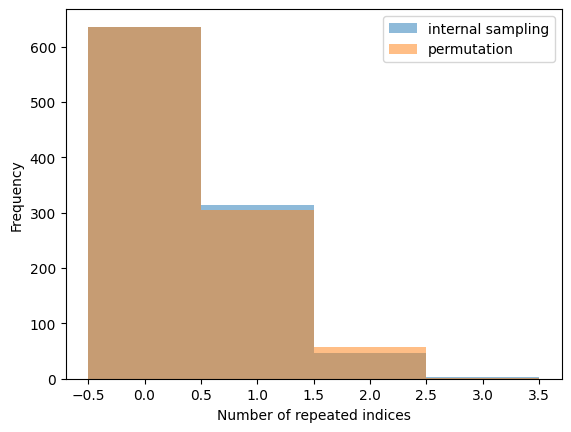

In [221]:
# Histogram of repeated counts
import matplotlib.pyplot as plt

plt.hist(repeated_counts, bins=np.arange(0, np.max(repeated_counts)+2)-0.5, alpha=0.5, label='internal sampling')
plt.hist(repeated_counts2, bins=np.arange(0, np.max(repeated_counts2)+2)-0.5, alpha=0.5, label='permutation')
plt.xlabel('Number of repeated indices')
plt.ylabel('Frequency')
plt.legend()
plt.show()


     Fraction_1  Fraction_2  Fraction_3
0           0.3         0.4         0.3
1           0.4         0.2         0.4
2           0.3         0.2         0.5
3           0.6         0.4         0.0
4           0.3         0.2         0.5
..          ...         ...         ...
995         0.3         0.5         0.2
996         0.4         0.4         0.2
997         0.2         0.6         0.2
998         0.5         0.2         0.3
999         0.6         0.1         0.3

[1000 rows x 3 columns]


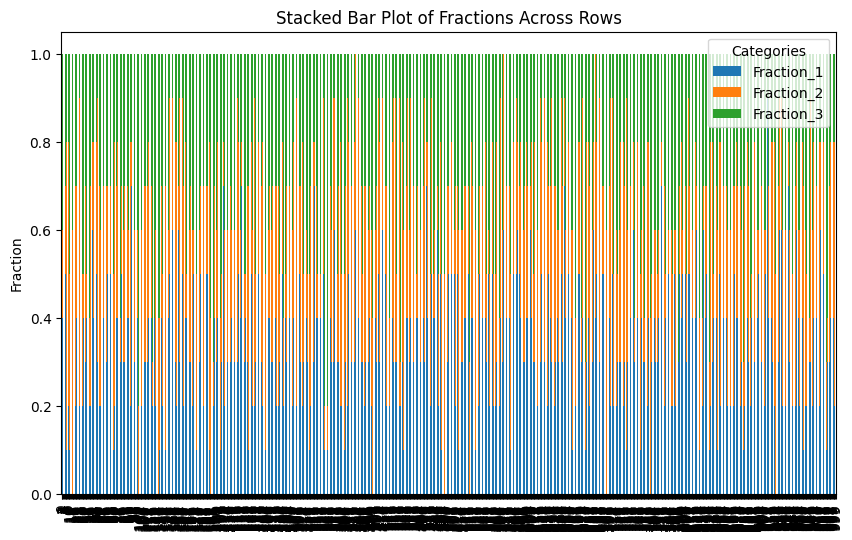

In [211]:
batch_cell_type = np.array(adata.obs[group_key].values[batch_indices_array])
batch_cell_type = np.char.replace(batch_cell_type.astype(str), 'cell_type_', '').astype(int)
# Convert batch_indices_array to corresponding cell type 
def calculate_fractions(arr):
    unique_values = np.unique(arr)  # Find unique values in the array
    column_names = [f'Fraction_{val}' for val in unique_values]  # Create column names

    fractions = []
    for row in arr:
        total_count = len(row)
        counts = [np.sum(row == x) for x in unique_values]
        fractions.append([count / total_count for count in counts])
    
    df = pd.DataFrame(fractions, columns=column_names)
    return df

cell_type_fraction = calculate_fractions(batch_cell_type)
print(cell_type_fraction)
import matplotlib.pyplot as plt
cell_type_fraction.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.ylabel("Fraction")
plt.title("Stacked Bar Plot of Fractions Across Rows")
plt.legend(title="Categories")
plt.show()


     Fraction_1  Fraction_2  Fraction_3
0           0.1         0.6         0.3
1           0.6         0.3         0.1
2           0.2         0.7         0.1
3           0.3         0.3         0.4
4           0.4         0.1         0.5
..          ...         ...         ...
995         0.6         0.1         0.3
996         0.5         0.2         0.3
997         0.2         0.4         0.4
998         0.2         0.5         0.3
999         0.5         0.2         0.3

[1000 rows x 3 columns]


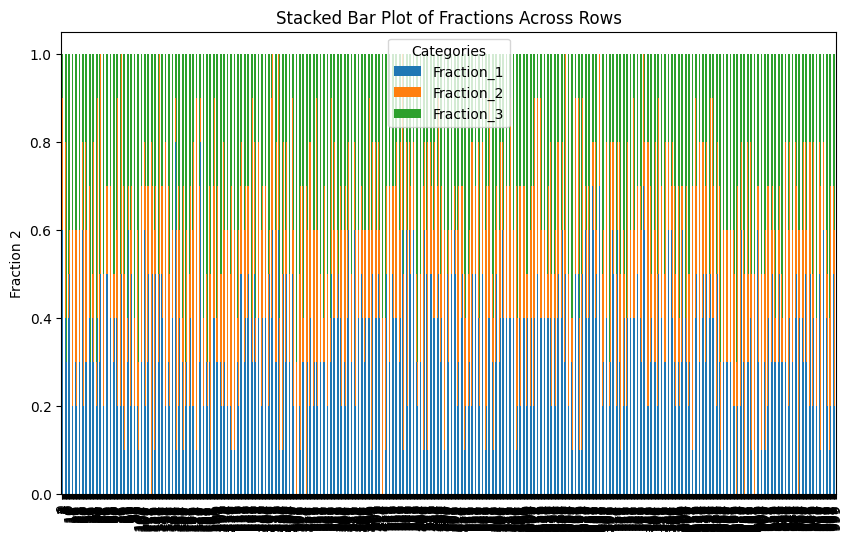

In [222]:
batch_cell_type2 = np.array(adata_permuted.obs[group_key].values[batch_indices_array2])
batch_cell_type2 = np.char.replace(batch_cell_type2.astype(str), 'cell_type_', '').astype(int)
# Convert batch_indices_array to corresponding cell type 
def calculate_fractions(arr):
    unique_values = np.unique(arr)  # Find unique values in the array
    column_names = [f'Fraction_{val}' for val in unique_values]  # Create column names

    fractions = []
    for row in arr:
        total_count = len(row)
        counts = [np.sum(row == x) for x in unique_values]
        fractions.append([count / total_count for count in counts])
    
    df = pd.DataFrame(fractions, columns=column_names)
    return df

cell_type_fraction2 = calculate_fractions(batch_cell_type2)
print(cell_type_fraction2)
import matplotlib.pyplot as plt
cell_type_fraction2.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.ylabel("Fraction 2")
plt.title("Stacked Bar Plot of Fractions Across Rows")
plt.legend(title="Categories")
plt.show()


In [223]:
# Plot the distribution of each cell type colored by 
cell_type_fraction['operation'] = 'none'
cell_type_fraction2['operation'] = 'permute'
cell_type_fraction_all = pd.concat([cell_type_fraction, cell_type_fraction2])

cell_type_fraction_all

,Fraction_1,Fraction_2,Fraction_3,operation
0,0.3,0.4,0.3,none
1,0.4,0.2,0.4,none
2,0.3,0.2,0.5,none
3,0.6,0.4,0.0,none
4,0.3,0.2,0.5,none
...,...,...,...,...
995,0.6,0.1,0.3,permute
996,0.5,0.2,0.3,permute
997,0.2,0.4,0.4,permute
998,0.2,0.5,0.3,permute


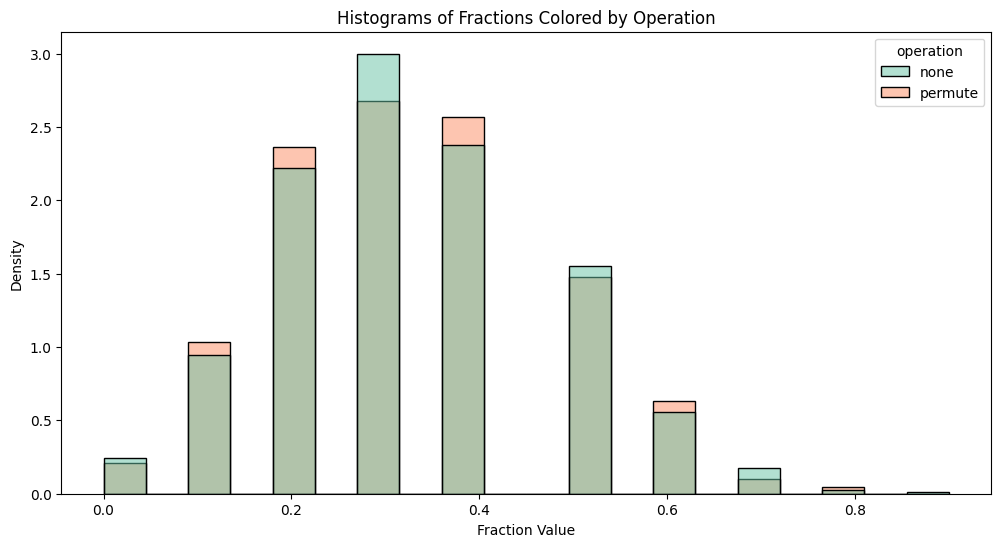

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = cell_type_fraction_all
# Create the plot
plt.figure(figsize=(12, 6))
sns.histplot(data=cell_type_fraction_all, x='Fraction_1', hue='operation', multiple='layer', bins=20, 
             kde=False, palette='Set2', stat="density")

# Add titles and labels
plt.title('Histograms of Fractions Colored by Operation')
plt.xlabel('Fraction Value')
plt.ylabel('Density')
plt.show()


     Fraction_1  Fraction_2
0           1.0         0.0
1           1.0         0.0
2           0.0         1.0
3           1.0         0.0
4           0.0         1.0
..          ...         ...
995         1.0         0.0
996         0.0         1.0
997         0.0         1.0
998         0.0         1.0
999         0.0         1.0

[1000 rows x 2 columns]


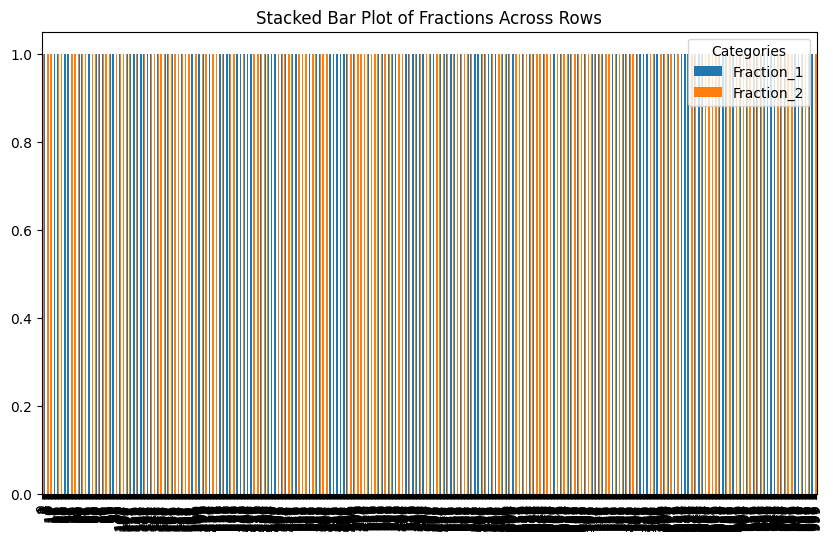

In [226]:
batch_domain = np.array(adata.obs[batch_key].values[batch_indices_array])
batch_domain = np.char.replace(batch_domain.astype(str), 'batch_', '').astype(int)

domain_fraction = calculate_fractions(batch_domain)
print(domain_fraction)
import matplotlib.pyplot as plt
domain_fraction.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Stacked Bar Plot of Fractions Across Rows")
plt.legend(title="Categories")
plt.show()


     Fraction_1  Fraction_2
0           1.0         0.0
1           1.0         0.0
2           0.0         1.0
3           0.0         1.0
4           0.0         1.0
..          ...         ...
995         0.0         1.0
996         0.0         1.0
997         1.0         0.0
998         1.0         0.0
999         0.0         1.0

[1000 rows x 2 columns]


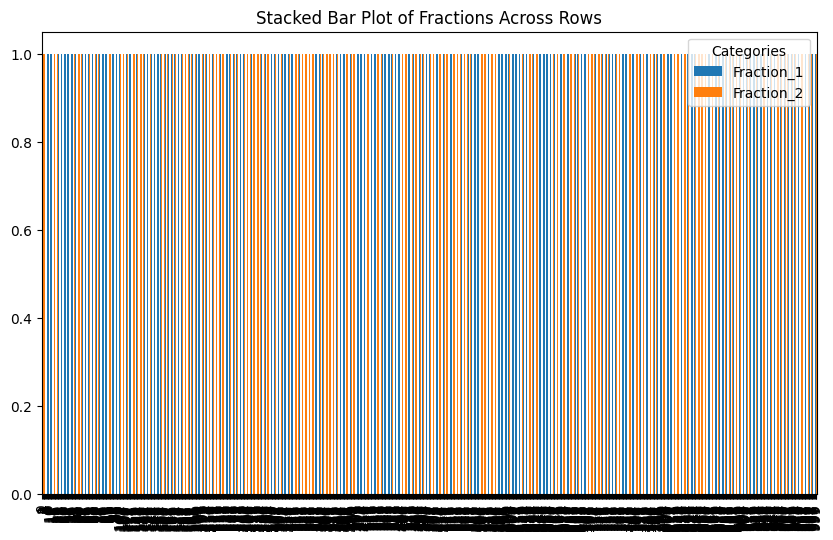

In [227]:
batch_domain2 = np.array(adata_permuted.obs[batch_key].values[batch_indices_array2])
batch_domain2 = np.char.replace(batch_domain2.astype(str), 'batch_', '').astype(int)

domain_fraction2 = calculate_fractions(batch_domain2)
print(domain_fraction2)
import matplotlib.pyplot as plt
domain_fraction2.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Stacked Bar Plot of Fractions Across Rows")
plt.legend(title="Categories")
plt.show()


In [228]:
domain_fraction['operation'] = 'none'
domain_fraction2['operation'] = 'permute'
domain_fraction_all = pd.concat([domain_fraction, domain_fraction2])

domain_fraction_all

,Fraction_1,Fraction_2,operation
0,1.0,0.0,none
1,1.0,0.0,none
2,0.0,1.0,none
3,1.0,0.0,none
4,0.0,1.0,none
...,...,...,...
995,0.0,1.0,permute
996,0.0,1.0,permute
997,1.0,0.0,permute
998,1.0,0.0,permute


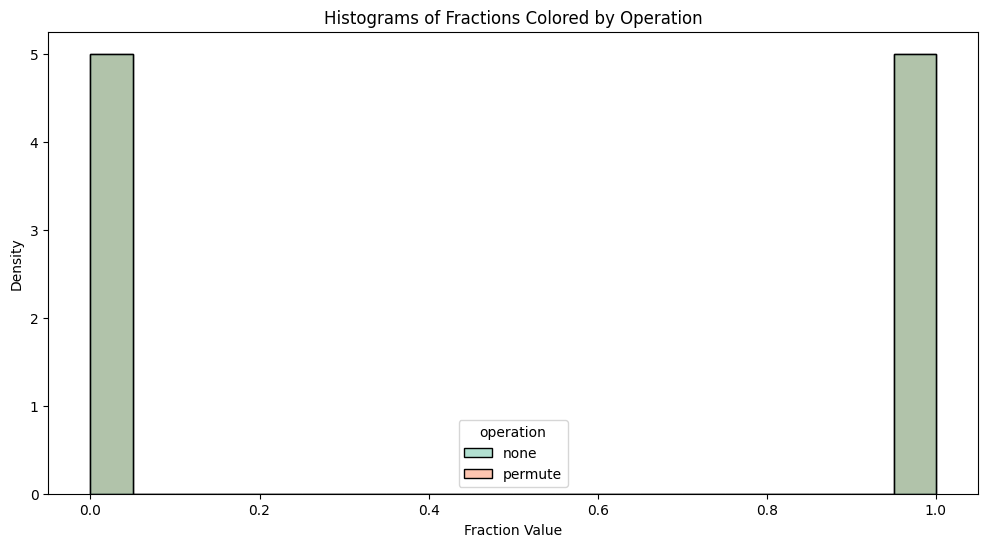

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = domain_fraction_all
# Create the plot
plt.figure(figsize=(12, 6))
sns.histplot(data=domain_fraction_all, x='Fraction_2', hue='operation', multiple='layer', bins=20, 
             kde=False, palette='Set2', stat="density")

# Add titles and labels
plt.title('Histograms of Fractions Colored by Operation')
plt.xlabel('Fraction Value')
plt.ylabel('Density')
plt.show()


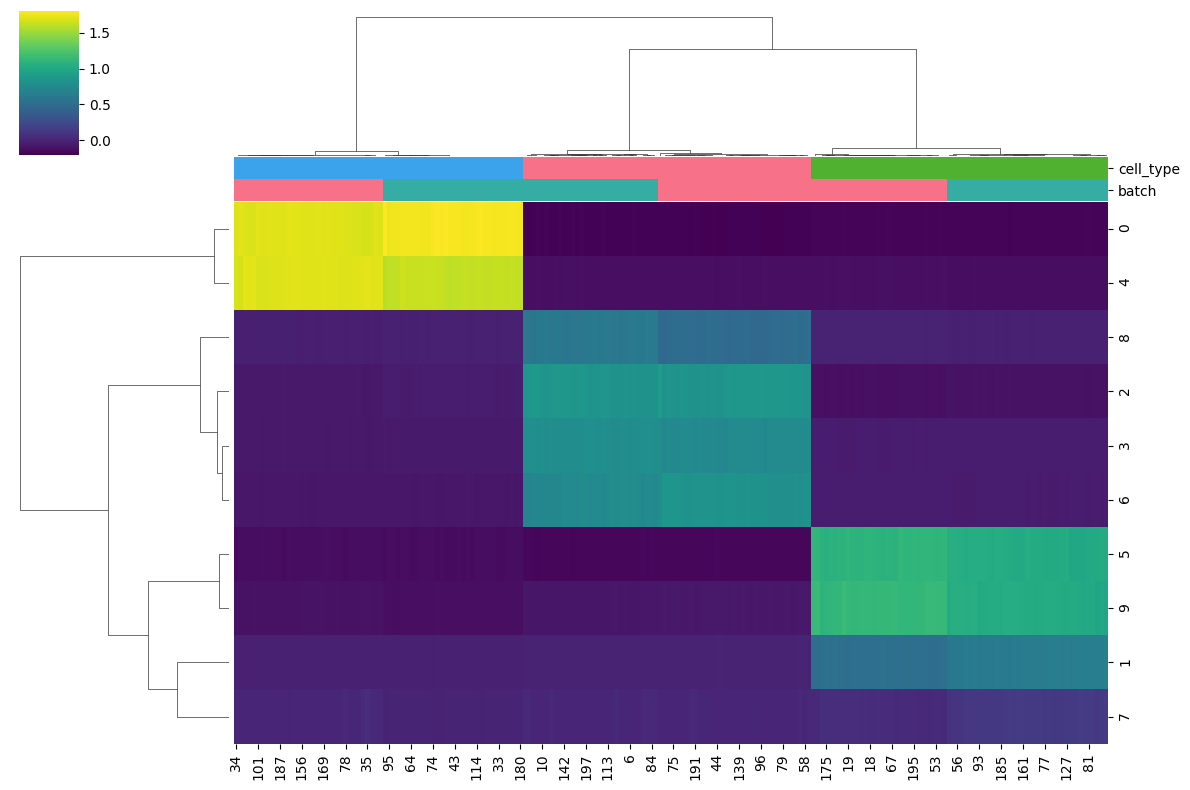

In [230]:
# Take the subset 
if amp_mode == 'permute':
    adata_plot = cur_ccd.adata.copy()[cur_ccd.adata.obs['datacopy'] == '0', :] 
elif amp_mode == 'sample':
    unique_obs_names, unique_indices = np.unique(cur_ccd.adata.obs_names, return_index=True)
    adata_plot = cur_ccd.adata[unique_indices, :].copy()
    print(adata_plot.shape)
else:
    adata_plot = cur_ccd.adata.copy()

ccd.pl.heatmap_with_annotations(adata_plot, val='Concord', obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_{amp_mode}_Concord_heatmap_{file_suffix}.png')

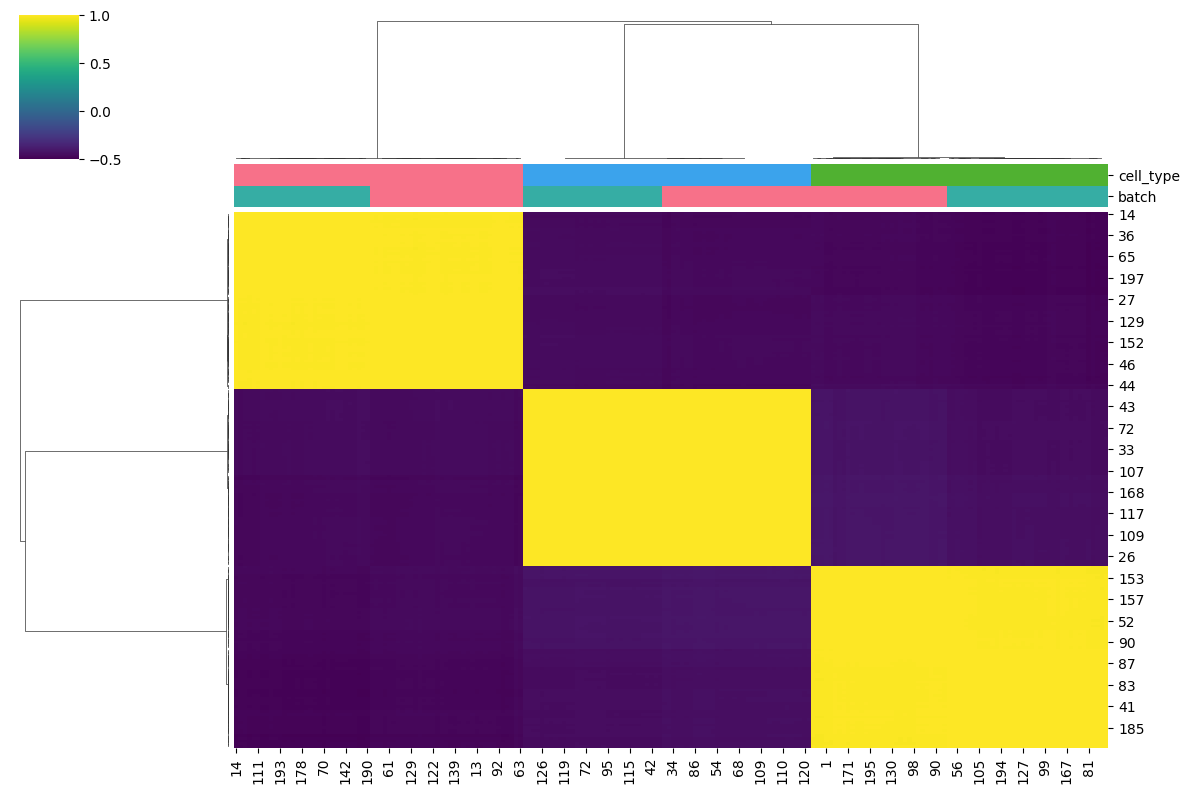

In [231]:
# Compute the correlation matrix
cor_mtx = np.corrcoef(adata_plot.obsm['Concord'], rowvar=True)
ccd.pl.heatmap_with_annotations(adata_plot, val=cor_mtx,
                                obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'{batch_mode}_{amp_mode}_Concord_correlation_{file_suffix}.png')

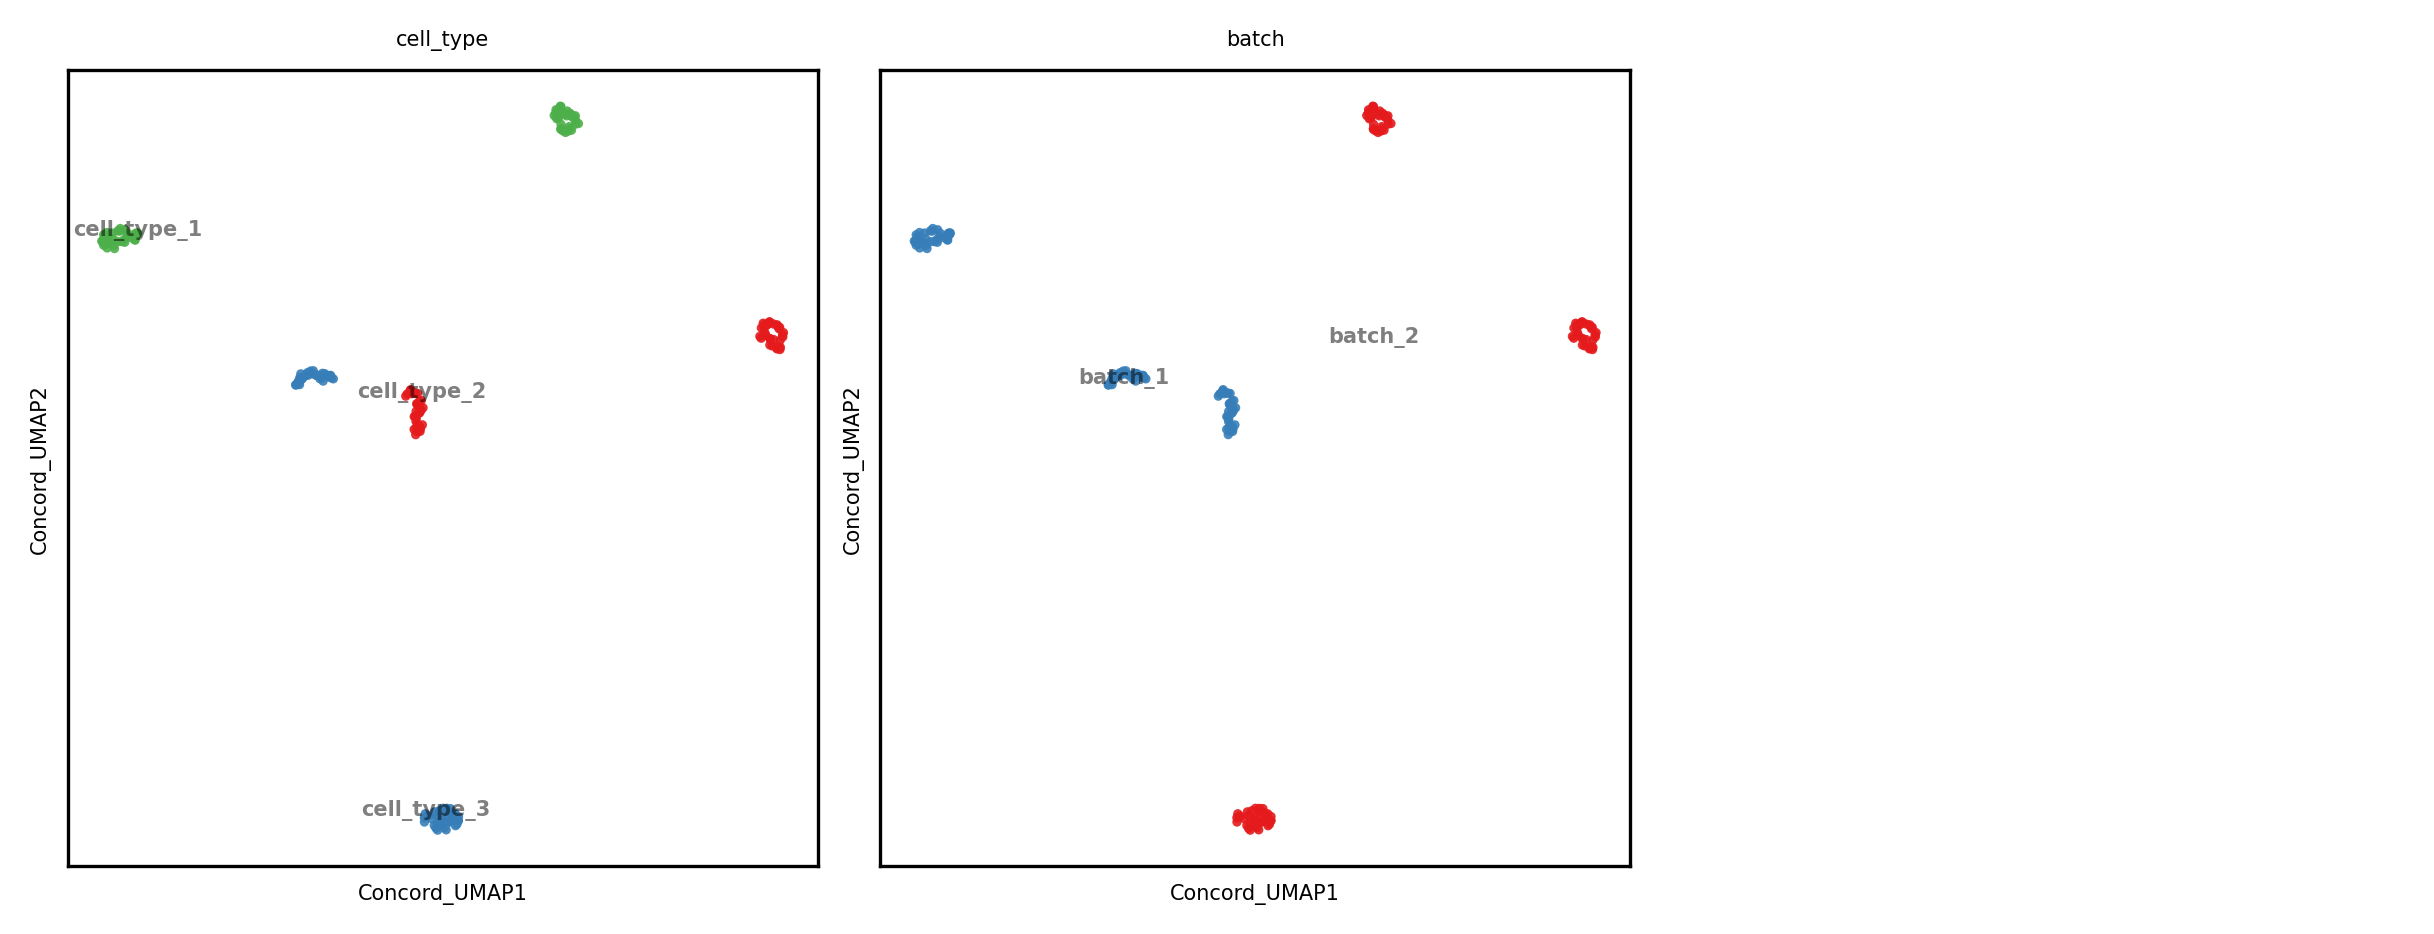

In [198]:
ccd.ul.run_umap(adata_plot, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'Concord'
show_basis = f'{output_key}_UMAP'
show_cols = [group_key, batch_key]
ccd.pl.plot_embedding(
    adata_plot, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"{batch_mode}_{amp_mode}_{show_basis}_{file_suffix}.png"
)